# This notebook does the 2-point and 3-point fits simultaneously

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
import pickle

In [4]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [6]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [7]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-7-2f60309b0160>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-2f60309b0160>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-2f60309b0160>:17: RuntimeWarning: invalid value encount

In [8]:
np.shape(gv_avg_data['FH'])

(64, 4)

#### Define functions

In [9]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [10]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [11]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [12]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction uses

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0s
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [13]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [14]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -1: ## t_sel[1] == -1 is the condition for the A3 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][0]], [FHdata_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -2: ## t_sel[1] == -2 is the condition for the V4 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][2]], [FHdata_t_sel_res[0][3]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt' in t.keys():
        out['3pt_combined'] = C_3pt(t['3pt'], p)
    if 'sum_sub' in t.keys():
        out['C^FH_combined'] = C_FH(t['sum_sub'], p)
    if 'FH' in t.keys():
        out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [15]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d

<ipython-input-15-e0790b6350f7>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])


#### Do the fits

In [16]:
num_zs = 7

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.67, 0.02)
prior['Z0'] = gv.gvar(0.0008, 0.0003)
prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)

#print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)


In [17]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all

#print(np.shape(y_all_dict['3pt_combined']))


fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p

<ipython-input-17-e5f134a9ec8d>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-17-e5f134a9ec8d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.79 [150]    Q = 0.97    logGBF = 3787

Parameters:
             E0       0.659421 +- 0.00549058             [     0.67 +- 0.02 ]  
             Z0   0.000742847 +- 3.09276e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00276996 +- 0.00013129             [   0.003 +- 0.003 ]  
       log(dE1)         -1.73617 +- 0.553417             [  -0.97551 +- 0.7 ]  *
             Z1   0.000271376 +- 0.000178707             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00181548 +- 0.000685076             [        0 +- 0.01 ]  
       log(dE2)         -1.14526 +- 0.398332             [  -0.97551 +- 0.7 ]  
             Z2   0.000592205 +- 0.000158931             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00330133 +- 0.00141372             [        0 +- 0.01 ]  
       log(dE3)        -0.840765 +- 0.413711             [  -0.97551 +- 0.7 ]  
             Z3    0.000746387 +- 0.00024178             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.00795

In [18]:
current_posterior = open('simul2pt3pt_n5_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

### Now, plot the data against the fit

In [19]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-19-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-19-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-19-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [20]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

#CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
#CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
#CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
#CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-20-01b164071101>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-20-01b164071101>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-20-01b164071101>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

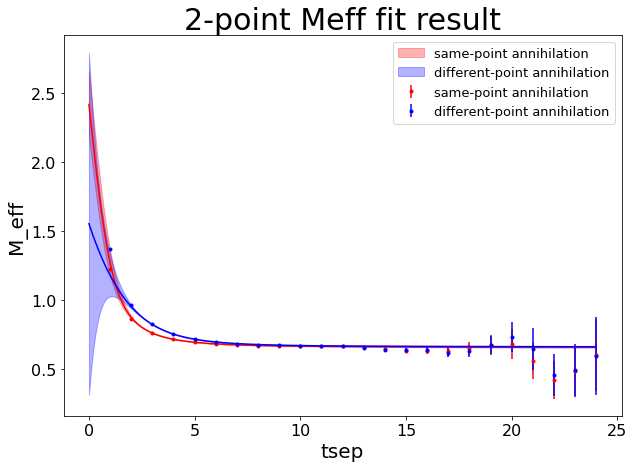

<Figure size 432x288 with 0 Axes>

In [21]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

In [22]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

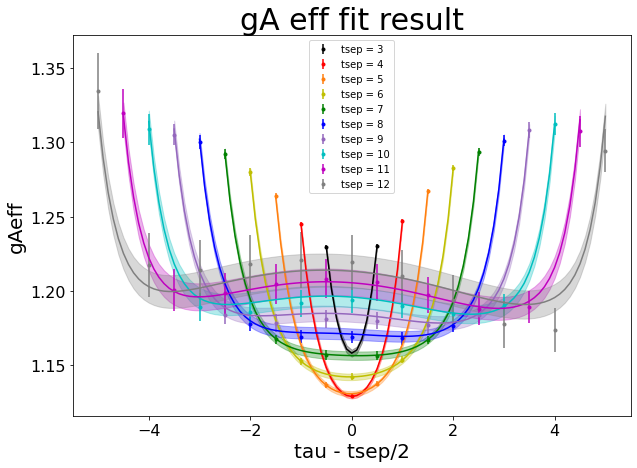

<Figure size 432x288 with 0 Axes>

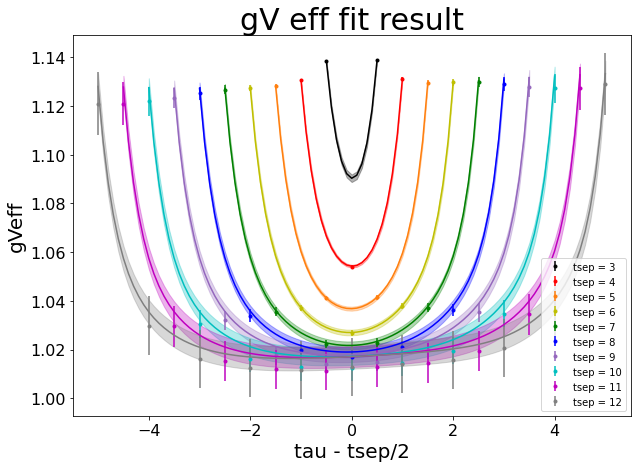

<Figure size 432x288 with 0 Axes>

In [23]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



#### Now, try the same, but with the 3-point data cut off at tau = 2

In [24]:
num_zs = 4
tau_cut_val = 2

x_2pt = np.array([l for l in range(3, 13)])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)


y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

x_all_tau2 = np.append(x_2pt_mod, x_1darray_tau2) 
y_all_tau2 = np.append(y_2pt_all, y_3pt_tau2)

x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

<ipython-input-24-d3eebb14bf85>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-24-d3eebb14bf85>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.75    logGBF = 2802

Parameters:
             E0        0.652961 +- 0.0079003             [     0.67 +- 0.02 ]  
             Z0    0.00070049 +- 5.07752e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00260417 +- 0.000211222             [   0.003 +- 0.003 ]  
       log(dE1)         -1.86904 +- 0.377055             [  -0.97551 +- 0.7 ]  *
             Z1   0.000436269 +- 9.46478e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00206758 +- 0.000327521             [        0 +- 0.01 ]  
       log(dE2)         -0.864027 +- 0.24411             [  -0.97551 +- 0.7 ]  
             Z2     0.000455978 +- 0.0001397             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00451001 +- 0.000839274             [        0 +- 0.01 ]  
       log(dE3)        -0.862002 +- 0.285044             [  -0.97551 +- 0.7 ]  
             Z3    0.00110186 +- 6.91179e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.007126

In [25]:
current_posterior = open('simul2pt3pt_tau2_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [26]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-26-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-26-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-26-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [27]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



<ipython-input-27-c7d185f82f5e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-27-c7d185f82f5e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-27-c7d185f82f5e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

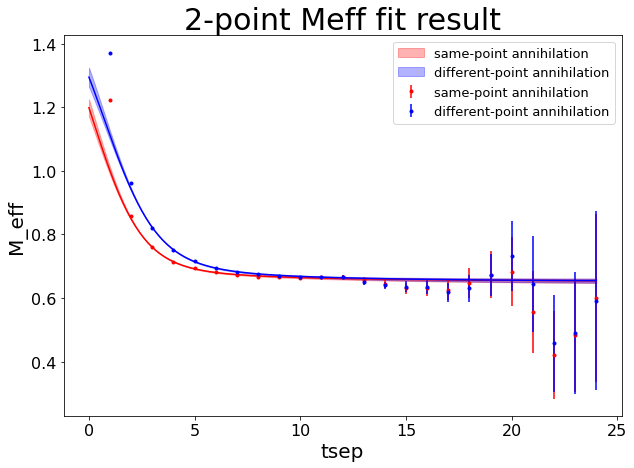

<Figure size 432x288 with 0 Axes>

In [28]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

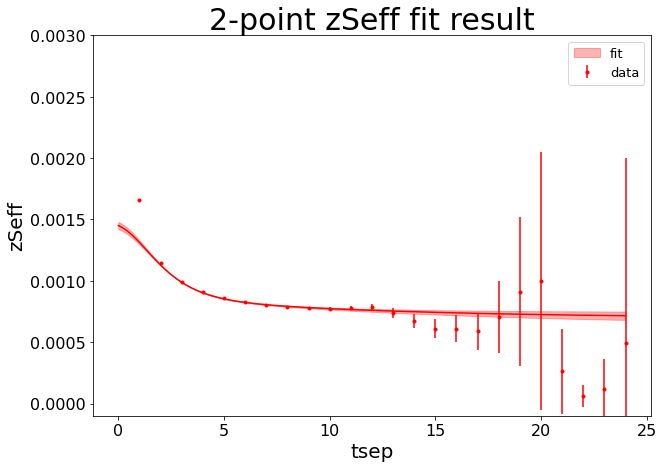

<Figure size 432x288 with 0 Axes>

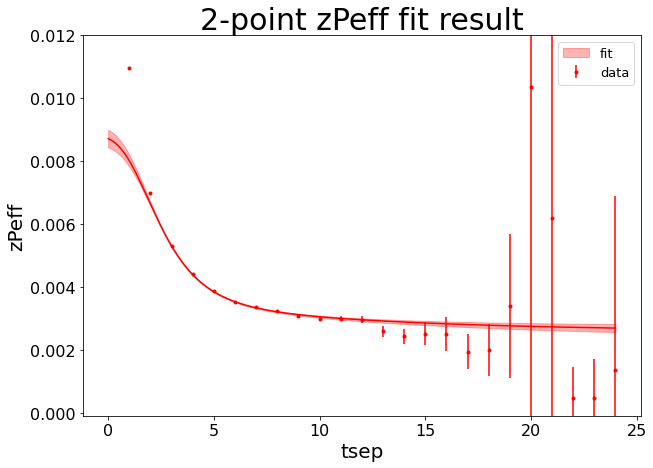

<Figure size 432x288 with 0 Axes>

In [29]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

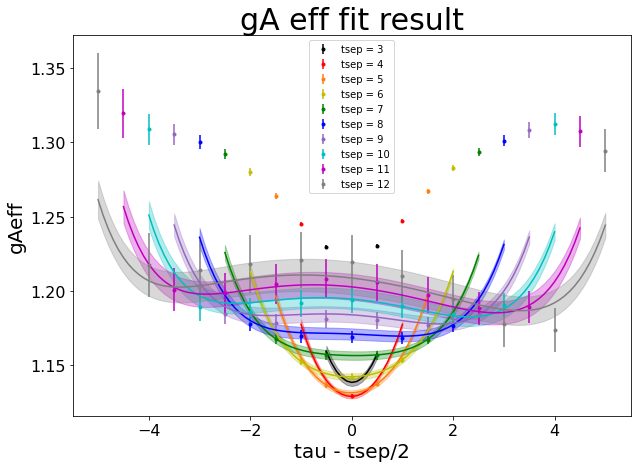

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

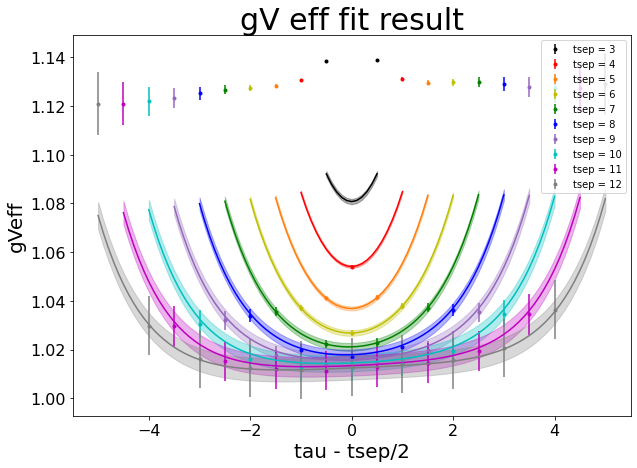

<Figure size 432x288 with 0 Axes>

In [30]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


### Now, include the fit to the Feynman-Hellman data in the chained fit

In [31]:
num_zs = 7
num_states_FH = 2

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.67, 0.02)
prior['Z0'] = gv.gvar(0.0008, 0.0003)
prior['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior["d_gA_ss_{}".format(n)] = gv.gvar(-0.0000015, 0.0000015)
    prior["d_gA_ps_{}".format(n)] = gv.gvar(-0.000009, 0.000009)
    prior["d_gV_ss_{}".format(n)] = gv.gvar(0.0000013, 0.0000013)
    prior["d_gV_ps_{}".format(n)] = gv.gvar(0.0000075, 0.0000075)
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 1)
    prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 1)
    prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 1)
    prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 1)
    
prior['gA3_FHmaxFHmax'] = gv.gvar(0, 1)
prior['gV4_FHmaxFHmax'] = gv.gvar(1, 0.2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior

0


In [32]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p
# chi2/dof [dof] = 0.85 [186]    Q = 0.94    logGBF = 3892.8
# chi2/dof [dof] = 0.83 [186]    Q = 0.96    logGBF = 3868.1
# chi2/dof [dof] = 0.8 [186]    Q = 0.98    logGBF = 3879.4

<ipython-input-32-bdfe00743b5f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-32-bdfe00743b5f>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.9 [186]    Q = 0.84    logGBF = 3941.5

Parameters:
             E0        0.659706 +- 0.00370327             [        0.67 +- 0.02 ]  
             Z0    0.000748051 +- 1.68543e-05             [    0.0008 +- 0.0003 ]  
        Ztilde0      0.00281471 +- 7.2613e-05             [      0.003 +- 0.003 ]  
       log(dE1)          -1.17212 +- 0.261096             [     -0.97551 +- 0.7 ]  
             Z1    0.000453992 +- 0.000112419             [    0.0012 +- 0.0006 ]  *
        Ztilde1     0.00280543 +- 0.000781748             [           0 +- 0.01 ]  
       log(dE2)         -0.871245 +- 0.294238             [     -0.97551 +- 0.7 ]  
             Z2    0.000715086 +- 0.000162541             [    0.0012 +- 0.0006 ]  
        Ztilde2      0.00530402 +- 0.00147344             [           0 +- 0.01 ]  
       log(dE3)          -0.65809 +- 0.429402             [     -0.97551 +- 0.7 ]  
             Z3     0.00092535 +- 0.000223474             [    0.001

In [33]:
current_posterior = open('simul2pt3pt_n5_withFH_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

#### Now, try the same, but with the 3-point data cut off at tau = 2

In [34]:
num_zs = 4
tau_cut_val = 3

# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt_all[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

<ipython-input-34-21d9589bf2ff>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-34-21d9589bf2ff>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.9 [186]    Q = 0.84    logGBF = 3941.5

Parameters:
             E0        0.659706 +- 0.00370327             [        0.67 +- 0.02 ]  
             Z0    0.000748051 +- 1.68543e-05             [    0.0008 +- 0.0003 ]  
        Ztilde0      0.00281471 +- 7.2613e-05             [      0.003 +- 0.003 ]  
       log(dE1)          -1.17212 +- 0.261096             [     -0.97551 +- 0.7 ]  
             Z1    0.000453992 +- 0.000112419             [    0.0012 +- 0.0006 ]  *
        Ztilde1     0.00280543 +- 0.000781748             [           0 +- 0.01 ]  
       log(dE2)         -0.871245 +- 0.294238             [     -0.97551 +- 0.7 ]  
             Z2    0.000715086 +- 0.000162541             [    0.0012 +- 0.0006 ]  
        Ztilde2      0.00530402 +- 0.00147344             [           0 +- 0.01 ]  
       log(dE3)          -0.65809 +- 0.429402             [     -0.97551 +- 0.7 ]  
             Z3     0.00092535 +- 0.000223474             [    0.001

Least Square Fit:
  chi2/dof [dof] = 0.82 [112]    Q = 0.92    logGBF = 2066.8

Parameters:
             E0           0.6592 +- 0.0032164             [        0.67 +- 0.02 ]  
             Z0    0.000747719 +- 1.32265e-05             [    0.0008 +- 0.0003 ]  
        Ztilde0      0.0028195 +- 5.70047e-05             [      0.003 +- 0.003 ]  
       log(dE1)         -0.973213 +- 0.141805             [     -0.97551 +- 0.7 ]  
             Z1    0.000591356 +- 6.94586e-05             [    0.0012 +- 0.0006 ]  *
        Ztilde1     0.00364969 +- 0.000560692             [           0 +- 0.01 ]  
       log(dE2)         -0.542753 +- 0.263195             [     -0.97551 +- 0.7 ]  
             Z2    0.000785519 +- 0.000286485             [    0.0012 +- 0.0006 ]  
        Ztilde2      0.00787186 +- 0.00265725             [           0 +- 0.01 ]  
       log(dE3)         -0.701336 +- 0.560152             [     -0.97551 +- 0.7 ]  
             Z3     0.00111668 +- 0.000283197             [    0.00

In [35]:
current_posterior = open('simul2pt3pt_tau2_withFH_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [36]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-36-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-36-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-36-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [37]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



<ipython-input-37-c7d185f82f5e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-37-c7d185f82f5e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-37-c7d185f82f5e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

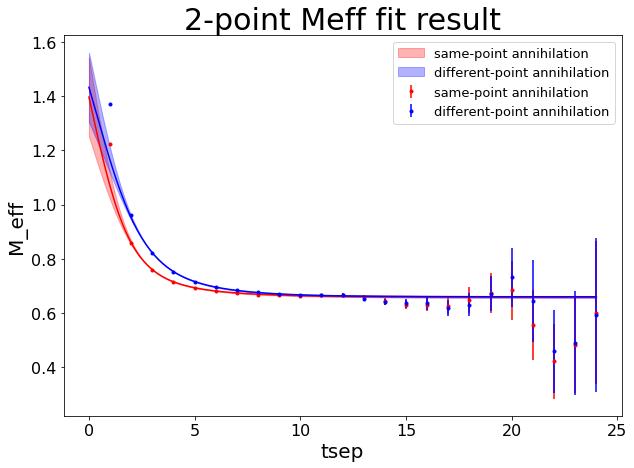

<Figure size 432x288 with 0 Axes>

In [38]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

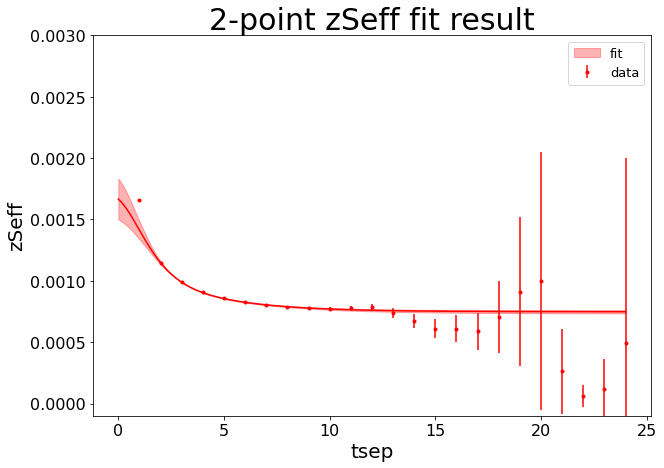

<Figure size 432x288 with 0 Axes>

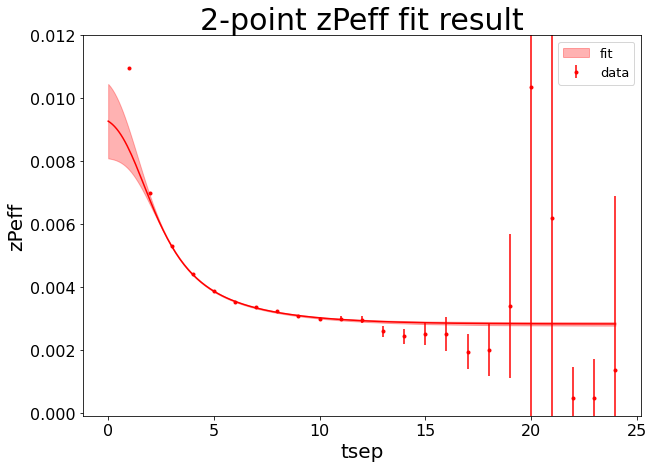

<Figure size 432x288 with 0 Axes>

In [39]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

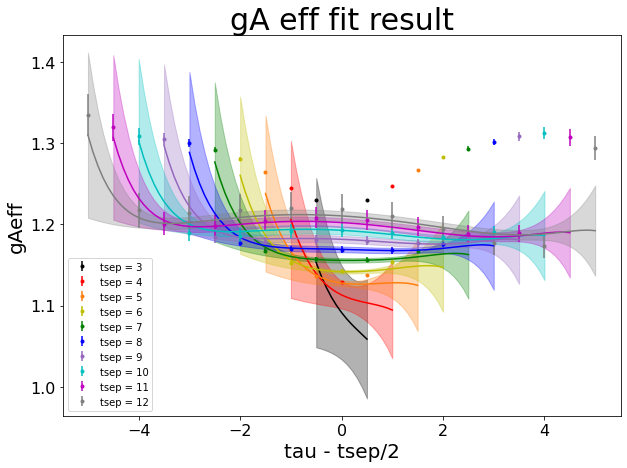

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

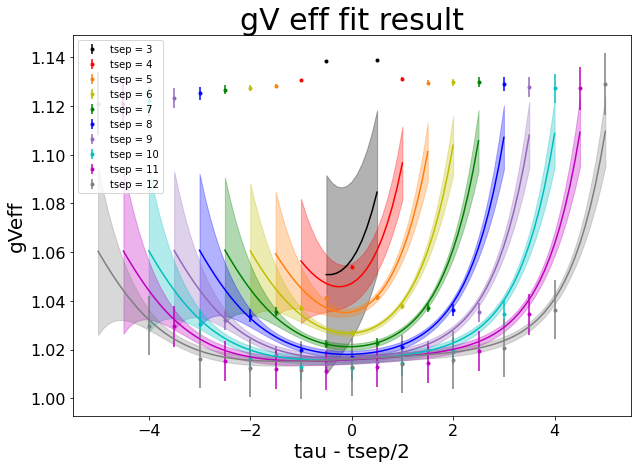

<Figure size 432x288 with 0 Axes>

In [40]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [41]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [42]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [43]:
list_LogGBF_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

In [44]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []
x_vals_all = []
y_vals_all = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    x_vals_all.append([])
    y_vals_all.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])
    
    x_vals_all[i] = np.append(x_2pt_mod, x_vals_3fit[i], axis = 0)
    y_vals_all[i] = np.append(y_2pt_all, y_vals_3fit[i], axis = 0)

<ipython-input-44-28236186c716>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-44-28236186c716>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Now that the priors and the data are set, do the fits

In [45]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[0][i][k],fcn=all_at_once,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[1][i][k],fcn=all_at_once,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[2][i][k],fcn=all_at_once,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0[i][j][k] = fit_a0.logGBF
            list_Q_a0[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv'))
            list_LogGBF_a1[i][j][k] = fit_a1.logGBF
            list_Q_a1[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2[i][j][k] = fit_a2.logGBF
            list_Q_a2[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2486.3

Parameters:
             E0      0.675854 +- 0.000981718             [     0.67 +- 0.02 ]  
             Z0   0.000799946 +- 2.37208e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311187 +- 1.12274e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.0604623 +- 0.007477             [  -0.97551 +- 0.1 ]  *****
             Z1    0.00123956 +- 1.03217e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0101982 +- 0.000115307             [        0 +- 0.01 ]  *
       log(dE2)        0.891279 +- 0.0082709             [  -0.97551 +- 0.7 ]  **
             Z2   -0.00626179 +- 0.000443846             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2      0.0644893 +- 0.00911333             [        0 +- 0.01 ]  *****
         gA3_00         1.0877 +- 0.00179089             [     1.25 +- 0.15 ]  *
         gV

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2486.3

Parameters:
             E0      0.675854 +- 0.000981718             [     0.67 +- 0.02 ]  
             Z0   0.000799946 +- 2.37208e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311187 +- 1.12274e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.0604623 +- 0.007477             [  -0.97551 +- 0.1 ]  *****
             Z1    0.00123956 +- 1.03217e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0101982 +- 0.000115307             [        0 +- 0.01 ]  *
       log(dE2)        0.891279 +- 0.0082709             [  -0.97551 +- 0.7 ]  **
             Z2   -0.00626179 +- 0.000443846             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2      0.0644893 +- 0.00911333             [        0 +- 0.01 ]  *****
         gA3_00         1.0877 +- 0.00179089             [     1.25 +- 0.15 ]  *
         gV

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 8.5e-13    logGBF = 3768.3

Parameters:
             E0        0.66238 +- 0.00196476             [     0.67 +- 0.02 ]  
             Z0   0.000760097 +- 6.63478e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286656 +- 2.9246e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.912135 +- 0.0481846             [  -0.97551 +- 0.1 ]  
             Z1    0.00056114 +- 2.80043e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00395903 +- 0.00015996             [        0 +- 0.01 ]  
       log(dE2)       -0.419191 +- 0.0449809             [  -0.97551 +- 0.7 ]  
             Z2    0.00114996 +- 2.90185e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00817755 +- 0.000259658             [        0 +- 0.01 ]  
       log(dE3)         1.33232 +- 0.0577122             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 8.5e-13    logGBF = 3768.3

Parameters:
             E0        0.66238 +- 0.00196476             [     0.67 +- 0.02 ]  
             Z0   0.000760097 +- 6.63478e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286656 +- 2.9246e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.912135 +- 0.0481846             [  -0.97551 +- 0.1 ]  
             Z1    0.00056114 +- 2.80043e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00395903 +- 0.00015996             [        0 +- 0.01 ]  
       log(dE2)       -0.419191 +- 0.0449809             [  -0.97551 +- 0.7 ]  
             Z2    0.00114996 +- 2.90185e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00817755 +- 0.000259658             [        0 +- 0.01 ]  
       log(dE3)         1.33232 +- 0.0577122             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.076    logGBF = 3803

Parameters:
             E0       0.657518 +- 0.00223599             [     0.67 +- 0.02 ]  
             Z0   0.000741981 +- 7.88629e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279421 +- 3.47117e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.86192 +- 0.0523897             [  -0.97551 +- 0.1 ]  *
             Z1   0.000705922 +- 2.73026e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00445207 +- 0.000210932             [        0 +- 0.01 ]  
       log(dE2)        0.0358164 +- 0.085834             [  -0.97551 +- 0.7 ]  *
             Z2    0.00135372 +- 0.000108818             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0155444 +- 0.00395657             [        0 +- 0.01 ]  *
       log(dE3)        -0.160292 +- 0.370811             [  -0.97551 +- 0.7 ]  *
             Z3    0.00

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.076    logGBF = 3803

Parameters:
             E0       0.657518 +- 0.00223599             [     0.67 +- 0.02 ]  
             Z0   0.000741981 +- 7.88629e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279421 +- 3.47117e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.86192 +- 0.0523897             [  -0.97551 +- 0.1 ]  *
             Z1   0.000705922 +- 2.73026e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00445207 +- 0.000210932             [        0 +- 0.01 ]  
       log(dE2)        0.0358164 +- 0.085834             [  -0.97551 +- 0.7 ]  *
             Z2    0.00135372 +- 0.000108818             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0155444 +- 0.00395657             [        0 +- 0.01 ]  *
       log(dE3)        -0.160292 +- 0.370811             [  -0.97551 +- 0.7 ]  *
             Z3    0.00

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51613

Parameters:
             E0         0.676775 +- 0.0118164             [     0.67 +- 0.02 ]  
             Z0    0.000235343 +- 1.24289e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 7.70322e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.966955 +- 0.0853912             [  -0.97551 +- 0.1 ]  
             Z1    0.000167198 +- 5.82747e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     -0.00784883 +- 0.00419764             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.582423             [  -0.97551 +- 0.7 ]  
             Z2    8.65411e-05 +- 0.000224446             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00724779 +- 0.00956324             [        0 +- 0.01 ]  
       log(dE3)          -0.96816 +- 0.578834             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51613

Parameters:
             E0         0.676775 +- 0.0118164             [     0.67 +- 0.02 ]  
             Z0    0.000235343 +- 1.24289e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 7.70322e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.966955 +- 0.0853912             [  -0.97551 +- 0.1 ]  
             Z1    0.000167198 +- 5.82747e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     -0.00784883 +- 0.00419764             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.582423             [  -0.97551 +- 0.7 ]  
             Z2    8.65411e-05 +- 0.000224446             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00724779 +- 0.00956324             [        0 +- 0.01 ]  
       log(dE3)          -0.96816 +- 0.578834             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [150]    Q = 0.96    logGBF = 3807.3

Parameters:
             E0       0.661642 +- 0.00306334             [     0.67 +- 0.02 ]  
             Z0   0.000757035 +- 1.19466e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285589 +- 4.95502e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.978792 +- 0.0918388             [  -0.97551 +- 0.1 ]  
             Z1    0.000514534 +- 9.8506e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00349123 +- 0.000496527             [        0 +- 0.01 ]  
       log(dE2)        -0.910339 +- 0.354666             [  -0.97551 +- 0.7 ]  
             Z2   0.000679606 +- 0.000212303             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00446768 +- 0.00197911             [        0 +- 0.01 ]  
       log(dE3)        -0.788522 +- 0.506204             [  -0.97551 +- 0.7 ]  
             Z3   0.0008

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [150]    Q = 0.96    logGBF = 3807.3

Parameters:
             E0       0.661642 +- 0.00306334             [     0.67 +- 0.02 ]  
             Z0   0.000757035 +- 1.19466e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285589 +- 4.95502e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.978792 +- 0.0918388             [  -0.97551 +- 0.1 ]  
             Z1    0.000514534 +- 9.8506e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00349123 +- 0.000496527             [        0 +- 0.01 ]  
       log(dE2)        -0.910339 +- 0.354666             [  -0.97551 +- 0.7 ]  
             Z2   0.000679606 +- 0.000212303             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00446768 +- 0.00197911             [        0 +- 0.01 ]  
       log(dE3)        -0.788522 +- 0.506204             [  -0.97551 +- 0.7 ]  
             Z3   0.0008

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00039    logGBF = 2797.2

Parameters:
             E0        0.66133 +- 0.00205368             [     0.67 +- 0.02 ]  
             Z0   0.000756259 +- 7.07251e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284937 +- 3.16663e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.908177 +- 0.0514457             [  -0.97551 +- 0.1 ]  
             Z1   0.000596222 +- 2.37402e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00410026 +- 0.000164066             [        0 +- 0.01 ]  
       log(dE2)       -0.319299 +- 0.0344643             [  -0.97551 +- 0.7 ]  
             Z2    0.00119852 +- 3.07447e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.0086243 +- 0.000277907             [        0 +- 0.01 ]  
         gA3_00         1.25176 +- 0.0112896             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00039    logGBF = 2797.2

Parameters:
             E0        0.66133 +- 0.00205368             [     0.67 +- 0.02 ]  
             Z0   0.000756259 +- 7.07251e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284937 +- 3.16663e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.908177 +- 0.0514457             [  -0.97551 +- 0.1 ]  
             Z1   0.000596222 +- 2.37402e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00410026 +- 0.000164066             [        0 +- 0.01 ]  
       log(dE2)       -0.319299 +- 0.0344643             [  -0.97551 +- 0.7 ]  
             Z2    0.00119852 +- 3.07447e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.0086243 +- 0.000277907             [        0 +- 0.01 ]  
         gA3_00         1.25176 +- 0.0112896             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.99 [110]    Q = 0.51    logGBF = 2810.9

Parameters:
             E0       0.664098 +- 0.00300478             [     0.67 +- 0.02 ]  
             Z0   0.000767726 +- 1.21354e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.00289329 +- 4.915e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.10319 +- 0.0932432             [  -0.97551 +- 0.1 ]  *
             Z1   0.000334214 +- 0.000136899             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00289917 +- 0.000691054             [        0 +- 0.01 ]  
       log(dE2)         -1.54773 +- 0.427218             [  -0.97551 +- 0.7 ]  
             Z2   0.000435192 +- 0.000170704             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00256565 +- 0.00125209             [        0 +- 0.01 ]  
       log(dE3)        -0.877492 +- 0.290779             [  -0.97551 +- 0.7 ]  
             Z3     0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.99 [110]    Q = 0.51    logGBF = 2810.9

Parameters:
             E0       0.664098 +- 0.00300478             [     0.67 +- 0.02 ]  
             Z0   0.000767726 +- 1.21354e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.00289329 +- 4.915e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.10319 +- 0.0932432             [  -0.97551 +- 0.1 ]  *
             Z1   0.000334214 +- 0.000136899             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00289917 +- 0.000691054             [        0 +- 0.01 ]  
       log(dE2)         -1.54773 +- 0.427218             [  -0.97551 +- 0.7 ]  
             Z2   0.000435192 +- 0.000170704             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00256565 +- 0.00125209             [        0 +- 0.01 ]  
       log(dE3)        -0.877492 +- 0.290779             [  -0.97551 +- 0.7 ]  
             Z3     0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2807.3

Parameters:
             E0       0.660799 +- 0.00336363             [     0.67 +- 0.02 ]  
             Z0   0.000754226 +- 1.34577e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284318 +- 5.54989e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01611 +- 0.0936813             [  -0.97551 +- 0.1 ]  
             Z1    0.00049098 +- 0.000124759             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0032981 +- 0.000574723             [        0 +- 0.01 ]  
       log(dE2)         -1.10112 +- 0.458366             [  -0.97551 +- 0.7 ]  
             Z2   0.000633689 +- 0.000204007             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00403194 +- 0.00196649             [        0 +- 0.01 ]  
       log(dE3)        -0.594283 +- 0.424471             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2807.3

Parameters:
             E0       0.660799 +- 0.00336363             [     0.67 +- 0.02 ]  
             Z0   0.000754226 +- 1.34577e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284318 +- 5.54989e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01611 +- 0.0936813             [  -0.97551 +- 0.1 ]  
             Z1    0.00049098 +- 0.000124759             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0032981 +- 0.000574723             [        0 +- 0.01 ]  
       log(dE2)         -1.10112 +- 0.458366             [  -0.97551 +- 0.7 ]  
             Z2   0.000633689 +- 0.000204007             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00403194 +- 0.00196649             [        0 +- 0.01 ]  
       log(dE3)        -0.594283 +- 0.424471             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2805.6

Parameters:
             E0       0.660784 +- 0.00337081             [     0.67 +- 0.02 ]  
             Z0   0.000754418 +- 1.35436e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284135 +- 5.55671e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01889 +- 0.0940836             [  -0.97551 +- 0.1 ]  
             Z1   0.000472406 +- 0.000142564             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0034146 +- 0.000666248             [        0 +- 0.01 ]  
       log(dE2)         -1.26419 +- 0.517074             [  -0.97551 +- 0.7 ]  
             Z2    0.00059897 +- 0.000221235             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00282564 +- 0.00261857             [        0 +- 0.01 ]  
       log(dE3)         -0.730755 +- 0.48174             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2805.6

Parameters:
             E0       0.660784 +- 0.00337081             [     0.67 +- 0.02 ]  
             Z0   0.000754418 +- 1.35436e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284135 +- 5.55671e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01889 +- 0.0940836             [  -0.97551 +- 0.1 ]  
             Z1   0.000472406 +- 0.000142564             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0034146 +- 0.000666248             [        0 +- 0.01 ]  
       log(dE2)         -1.26419 +- 0.517074             [  -0.97551 +- 0.7 ]  
             Z2    0.00059897 +- 0.000221235             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00282564 +- 0.00261857             [        0 +- 0.01 ]  
       log(dE3)         -0.730755 +- 0.48174             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2804.7

Parameters:
             E0       0.660765 +- 0.00337098             [     0.67 +- 0.02 ]  
             Z0   0.000754442 +- 1.35675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028402 +- 5.55723e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.02072 +- 0.094134             [  -0.97551 +- 0.1 ]  
             Z1   0.000464057 +- 0.000150185             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00348931 +- 0.000729901             [        0 +- 0.01 ]  
       log(dE2)         -1.32742 +- 0.527349             [  -0.97551 +- 0.7 ]  
             Z2    0.00058876 +- 0.000228799             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00233507 +- 0.0028704             [        0 +- 0.01 ]  
       log(dE3)         -0.80514 +- 0.507584             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2804.7

Parameters:
             E0       0.660765 +- 0.00337098             [     0.67 +- 0.02 ]  
             Z0   0.000754442 +- 1.35675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028402 +- 5.55723e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.02072 +- 0.094134             [  -0.97551 +- 0.1 ]  
             Z1   0.000464057 +- 0.000150185             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00348931 +- 0.000729901             [        0 +- 0.01 ]  
       log(dE2)         -1.32742 +- 0.527349             [  -0.97551 +- 0.7 ]  
             Z2    0.00058876 +- 0.000228799             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00233507 +- 0.0028704             [        0 +- 0.01 ]  
       log(dE3)         -0.80514 +- 0.507584             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.25    logGBF = 1917.5

Parameters:
             E0       0.659674 +- 0.00224515             [     0.67 +- 0.02 ]  
             Z0   0.000750691 +- 7.68849e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00282937 +- 3.44834e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.846906 +- 0.0575862             [  -0.97551 +- 0.1 ]  *
             Z1   0.000670502 +- 3.39344e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00447709 +- 0.000243525             [        0 +- 0.01 ]  
       log(dE2)        -0.168263 +- 0.081609             [  -0.97551 +- 0.7 ]  *
             Z2     0.00127213 +- 7.1283e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00947922 +- 0.000658885             [        0 +- 0.01 ]  
         gA3_00         1.22115 +- 0.0135675             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.25    logGBF = 1917.5

Parameters:
             E0       0.659674 +- 0.00224515             [     0.67 +- 0.02 ]  
             Z0   0.000750691 +- 7.68849e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00282937 +- 3.44834e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.846906 +- 0.0575862             [  -0.97551 +- 0.1 ]  *
             Z1   0.000670502 +- 3.39344e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00447709 +- 0.000243525             [        0 +- 0.01 ]  
       log(dE2)        -0.168263 +- 0.081609             [  -0.97551 +- 0.7 ]  *
             Z2     0.00127213 +- 7.1283e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00947922 +- 0.000658885             [        0 +- 0.01 ]  
         gA3_00         1.22115 +- 0.0135675             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1922.5

Parameters:
             E0       0.658526 +- 0.00314667             [     0.67 +- 0.02 ]  
             Z0   0.000744672 +- 1.21287e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280613 +- 5.12238e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.998061 +- 0.0882108             [  -0.97551 +- 0.1 ]  
             Z1   0.000591992 +- 6.06935e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00359681 +- 0.000363496             [        0 +- 0.01 ]  
       log(dE2)        -0.515327 +- 0.253181             [  -0.97551 +- 0.7 ]  
             Z2   0.000795573 +- 0.000279809             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00804708 +- 0.00268905             [        0 +- 0.01 ]  
       log(dE3)        -0.706067 +- 0.566392             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1922.5

Parameters:
             E0       0.658526 +- 0.00314667             [     0.67 +- 0.02 ]  
             Z0   0.000744672 +- 1.21287e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280613 +- 5.12238e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.998061 +- 0.0882108             [  -0.97551 +- 0.1 ]  
             Z1   0.000591992 +- 6.06935e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00359681 +- 0.000363496             [        0 +- 0.01 ]  
       log(dE2)        -0.515327 +- 0.253181             [  -0.97551 +- 0.7 ]  
             Z2   0.000795573 +- 0.000279809             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00804708 +- 0.00268905             [        0 +- 0.01 ]  
       log(dE3)        -0.706067 +- 0.566392             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1922

Parameters:
             E0       0.658336 +- 0.00315467             [     0.67 +- 0.02 ]  
             Z0   0.000743997 +- 1.21597e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280358 +- 5.12987e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.994 +- 0.0886403             [  -0.97551 +- 0.1 ]  
             Z1   0.000596439 +- 6.25824e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00361665 +- 0.000377613             [        0 +- 0.01 ]  
       log(dE2)        -0.554502 +- 0.286136             [  -0.97551 +- 0.7 ]  
             Z2   0.000760859 +- 0.000285036             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00730628 +- 0.00293913             [        0 +- 0.01 ]  
       log(dE3)        -0.791583 +- 0.609015             [  -0.97551 +- 0.7 ]  
             Z3   0.0008598

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1922

Parameters:
             E0       0.658336 +- 0.00315467             [     0.67 +- 0.02 ]  
             Z0   0.000743997 +- 1.21597e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280358 +- 5.12987e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.994 +- 0.0886403             [  -0.97551 +- 0.1 ]  
             Z1   0.000596439 +- 6.25824e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00361665 +- 0.000377613             [        0 +- 0.01 ]  
       log(dE2)        -0.554502 +- 0.286136             [  -0.97551 +- 0.7 ]  
             Z2   0.000760859 +- 0.000285036             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00730628 +- 0.00293913             [        0 +- 0.01 ]  
       log(dE3)        -0.791583 +- 0.609015             [  -0.97551 +- 0.7 ]  
             Z3   0.0008598

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1921.8

Parameters:
             E0        0.65825 +- 0.00316077             [     0.67 +- 0.02 ]  
             Z0   0.000743718 +- 1.21803e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280245 +- 5.13499e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.991602 +- 0.0887444             [  -0.97551 +- 0.1 ]  
             Z1   0.000598193 +- 6.39405e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00363006 +- 0.000382907             [        0 +- 0.01 ]  
       log(dE2)        -0.573083 +- 0.300963             [  -0.97551 +- 0.7 ]  
             Z2    0.00075358 +- 0.000276644             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00694614 +- 0.00304439             [        0 +- 0.01 ]  
       log(dE3)        -0.781756 +- 0.602976             [  -0.97551 +- 0.7 ]  
             Z3   0.00082

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1921.8

Parameters:
             E0        0.65825 +- 0.00316077             [     0.67 +- 0.02 ]  
             Z0   0.000743718 +- 1.21803e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280245 +- 5.13499e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.991602 +- 0.0887444             [  -0.97551 +- 0.1 ]  
             Z1   0.000598193 +- 6.39405e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00363006 +- 0.000382907             [        0 +- 0.01 ]  
       log(dE2)        -0.573083 +- 0.300963             [  -0.97551 +- 0.7 ]  
             Z2    0.00075358 +- 0.000276644             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00694614 +- 0.00304439             [        0 +- 0.01 ]  
       log(dE3)        -0.781756 +- 0.602976             [  -0.97551 +- 0.7 ]  
             Z3   0.00082

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.97    logGBF = 1921.8

Parameters:
             E0       0.658215 +- 0.00315958             [     0.67 +- 0.02 ]  
             Z0    0.000743604 +- 1.2169e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280197 +- 5.13142e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.990566 +- 0.0886584             [  -0.97551 +- 0.1 ]  
             Z1   0.000599065 +- 6.41483e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00363704 +- 0.000382768             [        0 +- 0.01 ]  
       log(dE2)        -0.572179 +- 0.300583             [  -0.97551 +- 0.7 ]  
             Z2   0.000760578 +- 0.000268344             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00692075 +- 0.00301961             [        0 +- 0.01 ]  
       log(dE3)        -0.752606 +- 0.593372             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.97    logGBF = 1921.8

Parameters:
             E0       0.658215 +- 0.00315958             [     0.67 +- 0.02 ]  
             Z0    0.000743604 +- 1.2169e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280197 +- 5.13142e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.990566 +- 0.0886584             [  -0.97551 +- 0.1 ]  
             Z1   0.000599065 +- 6.41483e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00363704 +- 0.000382768             [        0 +- 0.01 ]  
       log(dE2)        -0.572179 +- 0.300583             [  -0.97551 +- 0.7 ]  
             Z2   0.000760578 +- 0.000268344             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00692075 +- 0.00301961             [        0 +- 0.01 ]  
       log(dE3)        -0.752606 +- 0.593372             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2566.5

Parameters:
             E0       0.676206 +- 0.00097681             [     0.67 +- 0.02 ]  
             Z0   0.000801227 +- 2.35463e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00311768 +- 1.1148e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0509359 +- 0.00726421             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00124532 +- 1.06306e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1      0.010353 +- 0.000114737             [        0 +- 0.01 ]  *
       log(dE2)       0.902243 +- 0.00854588             [  -0.97551 +- 0.7 ]  **
             Z2     0.0071673 +- 0.000477116             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2       -0.0659248 +- 0.009164             [        0 +- 0.01 ]  *****
         gA3_00        1.08751 +- 0.00178134             [     1.25 +- 0.15 ]  *
         gV4_

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2566.5

Parameters:
             E0       0.676206 +- 0.00097681             [     0.67 +- 0.02 ]  
             Z0   0.000801227 +- 2.35463e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00311768 +- 1.1148e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0509359 +- 0.00726421             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00124532 +- 1.06306e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1      0.010353 +- 0.000114737             [        0 +- 0.01 ]  *
       log(dE2)       0.902243 +- 0.00854588             [  -0.97551 +- 0.7 ]  **
             Z2     0.0071673 +- 0.000477116             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2       -0.0659248 +- 0.009164             [        0 +- 0.01 ]  *****
         gA3_00        1.08751 +- 0.00178134             [     1.25 +- 0.15 ]  *
         gV4_

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.6e-13    logGBF = 3767.8

Parameters:
             E0       0.662545 +- 0.00195456             [     0.67 +- 0.02 ]  
             Z0   0.000761013 +- 6.63129e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287167 +- 2.95476e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.894935 +- 0.0538847             [  -0.97551 +- 0.3 ]  
             Z1   0.000564757 +- 2.90414e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00400915 +- 0.000181364             [        0 +- 0.01 ]  
       log(dE2)        -0.43227 +- 0.0494425             [  -0.97551 +- 0.7 ]  
             Z2     0.00114394 +- 3.0749e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00810354 +- 0.000283914             [        0 +- 0.01 ]  
       log(dE3)         1.33294 +- 0.0578718             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.6e-13    logGBF = 3767.8

Parameters:
             E0       0.662545 +- 0.00195456             [     0.67 +- 0.02 ]  
             Z0   0.000761013 +- 6.63129e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287167 +- 2.95476e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.894935 +- 0.0538847             [  -0.97551 +- 0.3 ]  
             Z1   0.000564757 +- 2.90414e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00400915 +- 0.000181364             [        0 +- 0.01 ]  
       log(dE2)        -0.43227 +- 0.0494425             [  -0.97551 +- 0.7 ]  
             Z2     0.00114394 +- 3.0749e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00810354 +- 0.000283914             [        0 +- 0.01 ]  
       log(dE3)         1.33294 +- 0.0578718             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.088    logGBF = 3803.9

Parameters:
             E0       0.658231 +- 0.00220034             [     0.67 +- 0.02 ]  
             Z0   0.000745386 +- 7.76987e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281041 +- 3.46372e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.824397 +- 0.0574057             [  -0.97551 +- 0.3 ]  
             Z1   0.000717106 +- 2.95549e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00459762 +- 0.000245043             [        0 +- 0.01 ]  
       log(dE2)        0.0328661 +- 0.089023             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134651 +- 0.000113188             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150759 +- 0.00389594             [        0 +- 0.01 ]  *
       log(dE3)        -0.175865 +- 0.385769             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.088    logGBF = 3803.9

Parameters:
             E0       0.658231 +- 0.00220034             [     0.67 +- 0.02 ]  
             Z0   0.000745386 +- 7.76987e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281041 +- 3.46372e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.824397 +- 0.0574057             [  -0.97551 +- 0.3 ]  
             Z1   0.000717106 +- 2.95549e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00459762 +- 0.000245043             [        0 +- 0.01 ]  
       log(dE2)        0.0328661 +- 0.089023             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134651 +- 0.000113188             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150759 +- 0.00389594             [        0 +- 0.01 ]  *
       log(dE3)        -0.175865 +- 0.385769             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51613

Parameters:
             E0         0.676775 +- 0.0123425             [     0.67 +- 0.02 ]  
             Z0    0.000235344 +- 1.25453e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 8.90641e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.966954 +- 0.143957             [  -0.97551 +- 0.3 ]  
             Z1    0.000167198 +- 5.89139e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     -0.00784883 +- 0.00448554             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.587601             [  -0.97551 +- 0.7 ]  
             Z2     8.6541e-05 +- 0.000249221             [ 0.0012 +- 0.0006 ]  *
        Ztilde2       0.0072478 +- 0.00968421             [        0 +- 0.01 ]  
       log(dE3)          -0.96816 +- 0.578846             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51613

Parameters:
             E0         0.676775 +- 0.0123425             [     0.67 +- 0.02 ]  
             Z0    0.000235344 +- 1.25453e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 8.90641e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.966954 +- 0.143957             [  -0.97551 +- 0.3 ]  
             Z1    0.000167198 +- 5.89139e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     -0.00784883 +- 0.00448554             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.587601             [  -0.97551 +- 0.7 ]  
             Z2     8.6541e-05 +- 0.000249221             [ 0.0012 +- 0.0006 ]  *
        Ztilde2       0.0072478 +- 0.00968421             [        0 +- 0.01 ]  
       log(dE3)          -0.96816 +- 0.578846             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [150]    Q = 0.96    logGBF = 3795.8

Parameters:
             E0       0.661393 +- 0.00382559             [     0.67 +- 0.02 ]  
             Z0    0.00075542 +- 1.70073e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00283629 +- 7.0464e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.23738 +- 0.253813             [  -0.97551 +- 0.3 ]  
             Z1   0.000329221 +- 0.000193727             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00273311 +- 0.00105449             [        0 +- 0.01 ]  
       log(dE2)          -1.37011 +- 0.47058             [  -0.97551 +- 0.7 ]  
             Z2   0.000591771 +- 0.000194091             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00264215 +- 0.00215726             [        0 +- 0.01 ]  
       log(dE3)        -0.852467 +- 0.429302             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.8 [150]    Q = 0.96    logGBF = 3795.8

Parameters:
             E0       0.661393 +- 0.00382559             [     0.67 +- 0.02 ]  
             Z0    0.00075542 +- 1.70073e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00283629 +- 7.0464e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.23738 +- 0.253813             [  -0.97551 +- 0.3 ]  
             Z1   0.000329221 +- 0.000193727             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00273311 +- 0.00105449             [        0 +- 0.01 ]  
       log(dE2)          -1.37011 +- 0.47058             [  -0.97551 +- 0.7 ]  
             Z2   0.000591771 +- 0.000194091             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00264215 +- 0.00215726             [        0 +- 0.01 ]  
       log(dE3)        -0.852467 +- 0.429302             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00043    logGBF = 2796.8

Parameters:
             E0       0.661635 +- 0.00205592             [     0.67 +- 0.02 ]  
             Z0   0.000757798 +- 7.15605e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285751 +- 3.25113e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.885811 +- 0.0585612             [  -0.97551 +- 0.3 ]  
             Z1     0.00060076 +- 2.5054e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00416814 +- 0.00019356             [        0 +- 0.01 ]  
       log(dE2)       -0.333678 +- 0.0399853             [  -0.97551 +- 0.7 ]  
             Z2    0.00119085 +- 3.31362e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00851873 +- 0.000318149             [        0 +- 0.01 ]  
         gA3_00         1.24804 +- 0.0118904             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00043    logGBF = 2796.8

Parameters:
             E0       0.661635 +- 0.00205592             [     0.67 +- 0.02 ]  
             Z0   0.000757798 +- 7.15605e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285751 +- 3.25113e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.885811 +- 0.0585612             [  -0.97551 +- 0.3 ]  
             Z1     0.00060076 +- 2.5054e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00416814 +- 0.00019356             [        0 +- 0.01 ]  
       log(dE2)       -0.333678 +- 0.0399853             [  -0.97551 +- 0.7 ]  
             Z2    0.00119085 +- 3.31362e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00851873 +- 0.000318149             [        0 +- 0.01 ]  
         gA3_00         1.24804 +- 0.0118904             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.94 [110]    Q = 0.66    logGBF = 2804.7

Parameters:
             E0        0.66001 +- 0.00484653             [     0.67 +- 0.02 ]  
             Z0    0.00074608 +- 2.39715e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279847 +- 9.82598e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.48251 +- 0.236341             [  -0.97551 +- 0.3 ]  *
             Z1   0.000359733 +- 0.000111717             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00205347 +- 0.000464934             [        0 +- 0.01 ]  
       log(dE2)           -1.1414 +- 0.33699             [  -0.97551 +- 0.7 ]  
             Z2    0.00044414 +- 0.000146534             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.0038244 +- 0.000778794             [        0 +- 0.01 ]  
       log(dE3)        -0.833295 +- 0.291831             [  -0.97551 +- 0.7 ]  
             Z3     0.

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.94 [110]    Q = 0.66    logGBF = 2804.7

Parameters:
             E0        0.66001 +- 0.00484653             [     0.67 +- 0.02 ]  
             Z0    0.00074608 +- 2.39715e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279847 +- 9.82598e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.48251 +- 0.236341             [  -0.97551 +- 0.3 ]  *
             Z1   0.000359733 +- 0.000111717             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00205347 +- 0.000464934             [        0 +- 0.01 ]  
       log(dE2)           -1.1414 +- 0.33699             [  -0.97551 +- 0.7 ]  
             Z2    0.00044414 +- 0.000146534             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.0038244 +- 0.000778794             [        0 +- 0.01 ]  
       log(dE3)        -0.833295 +- 0.291831             [  -0.97551 +- 0.7 ]  
             Z3     0.

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2804.3

Parameters:
             E0       0.659861 +- 0.00402139             [     0.67 +- 0.02 ]  
             Z0   0.000749228 +- 1.75592e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281924 +- 7.38328e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.15534 +- 0.228155             [  -0.97551 +- 0.3 ]  
             Z1    0.000444253 +- 0.00014542             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00281275 +- 0.000827675             [        0 +- 0.01 ]  
       log(dE2)         -1.03159 +- 0.423579             [  -0.97551 +- 0.7 ]  
             Z2   0.000670953 +- 0.000186418             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00457549 +- 0.00180978             [        0 +- 0.01 ]  
       log(dE3)        -0.548998 +- 0.404169             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2804.3

Parameters:
             E0       0.659861 +- 0.00402139             [     0.67 +- 0.02 ]  
             Z0   0.000749228 +- 1.75592e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281924 +- 7.38328e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.15534 +- 0.228155             [  -0.97551 +- 0.3 ]  
             Z1    0.000444253 +- 0.00014542             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00281275 +- 0.000827675             [        0 +- 0.01 ]  
       log(dE2)         -1.03159 +- 0.423579             [  -0.97551 +- 0.7 ]  
             Z2   0.000670953 +- 0.000186418             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00457549 +- 0.00180978             [        0 +- 0.01 ]  
       log(dE3)        -0.548998 +- 0.404169             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2801.6

Parameters:
             E0       0.659841 +- 0.00409469             [     0.67 +- 0.02 ]  
             Z0   0.000749468 +- 1.80888e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281564 +- 7.51955e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.19014 +- 0.241945             [  -0.97551 +- 0.3 ]  
             Z1   0.000402429 +- 0.000175846             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00279552 +- 0.000942748             [        0 +- 0.01 ]  
       log(dE2)         -1.23625 +- 0.499913             [  -0.97551 +- 0.7 ]  
             Z2    0.00062156 +- 0.000205762             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00326183 +- 0.0023076             [        0 +- 0.01 ]  
       log(dE3)        -0.737932 +- 0.481516             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2801.6

Parameters:
             E0       0.659841 +- 0.00409469             [     0.67 +- 0.02 ]  
             Z0   0.000749468 +- 1.80888e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281564 +- 7.51955e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.19014 +- 0.241945             [  -0.97551 +- 0.3 ]  
             Z1   0.000402429 +- 0.000175846             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00279552 +- 0.000942748             [        0 +- 0.01 ]  
       log(dE2)         -1.23625 +- 0.499913             [  -0.97551 +- 0.7 ]  
             Z2    0.00062156 +- 0.000205762             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00326183 +- 0.0023076             [        0 +- 0.01 ]  
       log(dE3)        -0.737932 +- 0.481516             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2800.5

Parameters:
             E0         0.6598 +- 0.00411408             [     0.67 +- 0.02 ]  
             Z0   0.000749401 +- 1.82553e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281347 +- 7.56673e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20405 +- 0.244355             [  -0.97551 +- 0.3 ]  
             Z1   0.000387638 +- 0.000184238             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00281349 +- 0.000984351             [        0 +- 0.01 ]  
       log(dE2)         -1.29417 +- 0.504691             [  -0.97551 +- 0.7 ]  
             Z2   0.000611223 +- 0.000212023             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00287478 +- 0.00244867             [        0 +- 0.01 ]  
       log(dE3)        -0.826191 +- 0.511314             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2800.5

Parameters:
             E0         0.6598 +- 0.00411408             [     0.67 +- 0.02 ]  
             Z0   0.000749401 +- 1.82553e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281347 +- 7.56673e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20405 +- 0.244355             [  -0.97551 +- 0.3 ]  
             Z1   0.000387638 +- 0.000184238             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00281349 +- 0.000984351             [        0 +- 0.01 ]  
       log(dE2)         -1.29417 +- 0.504691             [  -0.97551 +- 0.7 ]  
             Z2   0.000611223 +- 0.000212023             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00287478 +- 0.00244867             [        0 +- 0.01 ]  
       log(dE3)        -0.826191 +- 0.511314             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.31    logGBF = 1918.7

Parameters:
             E0       0.660489 +- 0.00219159             [     0.67 +- 0.02 ]  
             Z0   0.000754524 +- 7.48974e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284912 +- 3.41596e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.7896 +- 0.0644938             [  -0.97551 +- 0.3 ]  
             Z1   0.000693811 +- 3.79353e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00471855 +- 0.000298456             [        0 +- 0.01 ]  
       log(dE2)        -0.153756 +- 0.091059             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128306 +- 8.25993e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00943964 +- 0.000741416             [        0 +- 0.01 ]  
         gA3_00         1.21559 +- 0.0128623             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.31    logGBF = 1918.7

Parameters:
             E0       0.660489 +- 0.00219159             [     0.67 +- 0.02 ]  
             Z0   0.000754524 +- 7.48974e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284912 +- 3.41596e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.7896 +- 0.0644938             [  -0.97551 +- 0.3 ]  
             Z1   0.000693811 +- 3.79353e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00471855 +- 0.000298456             [        0 +- 0.01 ]  
       log(dE2)        -0.153756 +- 0.091059             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128306 +- 8.25993e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00943964 +- 0.000741416             [        0 +- 0.01 ]  
         gA3_00         1.21559 +- 0.0128623             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1921.1

Parameters:
             E0       0.657937 +- 0.00365703             [     0.67 +- 0.02 ]  
             Z0   0.000741609 +- 1.54954e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.002792 +- 6.72693e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.04647 +- 0.169431             [  -0.97551 +- 0.3 ]  
             Z1   0.000577742 +- 7.43401e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344073 +- 0.000566132             [        0 +- 0.01 ]  
       log(dE2)        -0.517066 +- 0.249026             [  -0.97551 +- 0.7 ]  
             Z2     0.0007973 +- 0.000275999             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00809715 +- 0.00264393             [        0 +- 0.01 ]  
       log(dE3)        -0.714249 +- 0.567821             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1921.1

Parameters:
             E0       0.657937 +- 0.00365703             [     0.67 +- 0.02 ]  
             Z0   0.000741609 +- 1.54954e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.002792 +- 6.72693e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.04647 +- 0.169431             [  -0.97551 +- 0.3 ]  
             Z1   0.000577742 +- 7.43401e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344073 +- 0.000566132             [        0 +- 0.01 ]  
       log(dE2)        -0.517066 +- 0.249026             [  -0.97551 +- 0.7 ]  
             Z2     0.0007973 +- 0.000275999             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00809715 +- 0.00264393             [        0 +- 0.01 ]  
       log(dE3)        -0.714249 +- 0.567821             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1920.6

Parameters:
             E0        0.65786 +- 0.00365409             [     0.67 +- 0.02 ]  
             Z0      0.0007415 +- 1.5454e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279199 +- 6.69828e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.03598 +- 0.172539             [  -0.97551 +- 0.3 ]  
             Z1    0.00058251 +- 7.90647e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00347453 +- 0.000606329             [        0 +- 0.01 ]  
       log(dE2)         -0.56456 +- 0.288739             [  -0.97551 +- 0.7 ]  
             Z2   0.000758819 +- 0.000286476             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00726075 +- 0.0029456             [        0 +- 0.01 ]  
       log(dE3)        -0.805873 +- 0.616426             [  -0.97551 +- 0.7 ]  
             Z3   0.00084

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1920.6

Parameters:
             E0        0.65786 +- 0.00365409             [     0.67 +- 0.02 ]  
             Z0      0.0007415 +- 1.5454e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279199 +- 6.69828e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.03598 +- 0.172539             [  -0.97551 +- 0.3 ]  
             Z1    0.00058251 +- 7.90647e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00347453 +- 0.000606329             [        0 +- 0.01 ]  
       log(dE2)         -0.56456 +- 0.288739             [  -0.97551 +- 0.7 ]  
             Z2   0.000758819 +- 0.000286476             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00726075 +- 0.0029456             [        0 +- 0.01 ]  
       log(dE3)        -0.805873 +- 0.616426             [  -0.97551 +- 0.7 ]  
             Z3   0.00084

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1920.5

Parameters:
             E0         0.65785 +- 0.0036383             [     0.67 +- 0.02 ]  
             Z0   0.000741609 +- 1.53349e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279257 +- 6.64457e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.02887 +- 0.172757             [  -0.97551 +- 0.3 ]  
             Z1   0.000584813 +- 8.18341e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00350034 +- 0.000622834             [        0 +- 0.01 ]  
       log(dE2)         -0.588149 +- 0.30822             [  -0.97551 +- 0.7 ]  
             Z2   0.000749123 +- 0.000280841             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0068417 +- 0.00309549             [        0 +- 0.01 ]  
       log(dE3)        -0.798758 +- 0.612251             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1920.5

Parameters:
             E0         0.65785 +- 0.0036383             [     0.67 +- 0.02 ]  
             Z0   0.000741609 +- 1.53349e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279257 +- 6.64457e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.02887 +- 0.172757             [  -0.97551 +- 0.3 ]  
             Z1   0.000584813 +- 8.18341e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00350034 +- 0.000622834             [        0 +- 0.01 ]  
       log(dE2)         -0.588149 +- 0.30822             [  -0.97551 +- 0.7 ]  
             Z2   0.000749123 +- 0.000280841             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0068417 +- 0.00309549             [        0 +- 0.01 ]  
       log(dE3)        -0.798758 +- 0.612251             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1920.6

Parameters:
             E0       0.657846 +- 0.00361615             [     0.67 +- 0.02 ]  
             Z0   0.000741665 +- 1.51977e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279287 +- 6.58979e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.02463 +- 0.171035             [  -0.97551 +- 0.3 ]  
             Z1   0.000586833 +- 8.18853e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0035185 +- 0.000620841             [        0 +- 0.01 ]  
       log(dE2)        -0.583794 +- 0.305738             [  -0.97551 +- 0.7 ]  
             Z2   0.000759079 +- 0.000271691             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00685368 +- 0.00305849             [        0 +- 0.01 ]  
       log(dE3)        -0.764822 +- 0.602763             [  -0.97551 +- 0.7 ]  
             Z3   0.00081

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1920.6

Parameters:
             E0       0.657846 +- 0.00361615             [     0.67 +- 0.02 ]  
             Z0   0.000741665 +- 1.51977e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279287 +- 6.58979e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.02463 +- 0.171035             [  -0.97551 +- 0.3 ]  
             Z1   0.000586833 +- 8.18853e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0035185 +- 0.000620841             [        0 +- 0.01 ]  
       log(dE2)        -0.583794 +- 0.305738             [  -0.97551 +- 0.7 ]  
             Z2   0.000759079 +- 0.000271691             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00685368 +- 0.00305849             [        0 +- 0.01 ]  
       log(dE3)        -0.764822 +- 0.602763             [  -0.97551 +- 0.7 ]  
             Z3   0.00081

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2569.1

Parameters:
             E0     0.676209 +- 0.000976687            [     0.67 +- 0.02 ]  
             Z0   0.000801241 +- 2.3542e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00311777 +- 1.11464e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0506608 +- 0.00726144            [  -0.97551 +- 0.5 ]  *
             Z1   0.00124561 +- 1.06324e-05            [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.0103552 +- 0.000114674            [        0 +- 0.01 ]  *
       log(dE2)      0.902529 +- 0.00855737            [  -0.97551 +- 0.7 ]  **
             Z2   0.00717331 +- 0.000477299            [ 0.0012 +- 0.0006 ]  *****
        Ztilde2    -0.0659469 +- 0.00916639            [        0 +- 0.01 ]  *****
         gA3_00        1.0875 +- 0.00178104            [     1.25 +- 0.15 ]  *
         gV4_00      1.00664 +- 0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2569.1

Parameters:
             E0     0.676209 +- 0.000976687            [     0.67 +- 0.02 ]  
             Z0   0.000801241 +- 2.3542e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00311777 +- 1.11464e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0506608 +- 0.00726144            [  -0.97551 +- 0.5 ]  *
             Z1   0.00124561 +- 1.06324e-05            [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.0103552 +- 0.000114674            [        0 +- 0.01 ]  *
       log(dE2)      0.902529 +- 0.00855737            [  -0.97551 +- 0.7 ]  **
             Z2   0.00717331 +- 0.000477299            [ 0.0012 +- 0.0006 ]  *****
        Ztilde2    -0.0659469 +- 0.00916639            [        0 +- 0.01 ]  *****
         gA3_00        1.0875 +- 0.00178104            [     1.25 +- 0.15 ]  *
         gV4_00      1.00664 +- 0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.7e-13    logGBF = 3767.3

Parameters:
             E0       0.662562 +- 0.00195352             [     0.67 +- 0.02 ]  
             Z0   0.000761108 +- 6.63063e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028722 +- 2.95754e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.893155 +- 0.0544291             [  -0.97551 +- 0.5 ]  
             Z1   0.000565138 +- 2.91538e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00401445 +- 0.000183571             [        0 +- 0.01 ]  
       log(dE2)        -0.433654 +- 0.049909             [  -0.97551 +- 0.7 ]  
             Z2     0.0011433 +- 3.09322e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00809571 +- 0.000286478             [        0 +- 0.01 ]  
       log(dE3)         1.33299 +- 0.0578876             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.7e-13    logGBF = 3767.3

Parameters:
             E0       0.662562 +- 0.00195352             [     0.67 +- 0.02 ]  
             Z0   0.000761108 +- 6.63063e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028722 +- 2.95754e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.893155 +- 0.0544291             [  -0.97551 +- 0.5 ]  
             Z1   0.000565138 +- 2.91538e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00401445 +- 0.000183571             [        0 +- 0.01 ]  
       log(dE2)        -0.433654 +- 0.049909             [  -0.97551 +- 0.7 ]  
             Z2     0.0011433 +- 3.09322e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00809571 +- 0.000286478             [        0 +- 0.01 ]  
       log(dE3)         1.33299 +- 0.0578876             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.089    logGBF = 3803.6

Parameters:
             E0       0.658303 +- 0.00219612             [     0.67 +- 0.02 ]  
             Z0   0.000745724 +- 7.75333e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281203 +- 3.46043e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.82061 +- 0.0578035             [  -0.97551 +- 0.5 ]  
             Z1   0.000718295 +- 2.97839e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00461287 +- 0.000248305             [        0 +- 0.01 ]  
       log(dE2)       0.0325305 +- 0.0893312             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134552 +- 0.000113704             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150266 +- 0.00388803             [        0 +- 0.01 ]  *
       log(dE3)        -0.177715 +- 0.387251             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.089    logGBF = 3803.6

Parameters:
             E0       0.658303 +- 0.00219612             [     0.67 +- 0.02 ]  
             Z0   0.000745724 +- 7.75333e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281203 +- 3.46043e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.82061 +- 0.0578035             [  -0.97551 +- 0.5 ]  
             Z1   0.000718295 +- 2.97839e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00461287 +- 0.000248305             [        0 +- 0.01 ]  
       log(dE2)       0.0325305 +- 0.0893312             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134552 +- 0.000113704             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150266 +- 0.00388803             [        0 +- 0.01 ]  *
       log(dE3)        -0.177715 +- 0.387251             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51614

Parameters:
             E0         0.676775 +- 0.012479             [     0.67 +- 0.02 ]  
             Z0   0.000235344 +- 1.25762e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00123122 +- 9.20073e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.966954 +- 0.155902             [  -0.97551 +- 0.5 ]  
             Z1   0.000167198 +- 5.90831e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    -0.00784883 +- 0.00455925             [        0 +- 0.01 ]  
       log(dE2)        -0.969232 +- 0.588974             [  -0.97551 +- 0.7 ]  
             Z2    8.6541e-05 +- 0.000255422             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.0072478 +- 0.00971621             [        0 +- 0.01 ]  
       log(dE3)         -0.96816 +- 0.578849             [  -0.97551 +- 0.7 ]  
             Z3   -0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51614

Parameters:
             E0         0.676775 +- 0.012479             [     0.67 +- 0.02 ]  
             Z0   0.000235344 +- 1.25762e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00123122 +- 9.20073e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.966954 +- 0.155902             [  -0.97551 +- 0.5 ]  
             Z1   0.000167198 +- 5.90831e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    -0.00784883 +- 0.00455925             [        0 +- 0.01 ]  
       log(dE2)        -0.969232 +- 0.588974             [  -0.97551 +- 0.7 ]  
             Z2    8.6541e-05 +- 0.000255422             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.0072478 +- 0.00971621             [        0 +- 0.01 ]  
       log(dE3)         -0.96816 +- 0.578849             [  -0.97551 +- 0.7 ]  
             Z3   -0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [150]    Q = 0.97    logGBF = 3790.5

Parameters:
             E0       0.660389 +- 0.00467046             [     0.67 +- 0.02 ]  
             Z0   0.000749495 +- 2.33462e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280451 +- 9.77688e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.4977 +- 0.405364             [  -0.97551 +- 0.5 ]  *
             Z1   0.000283449 +- 0.000186621             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00211345 +- 0.000861046             [        0 +- 0.01 ]  
       log(dE2)          -1.2425 +- 0.426137             [  -0.97551 +- 0.7 ]  
             Z2   0.000595401 +- 0.000170056             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00311256 +- 0.00163665             [        0 +- 0.01 ]  
       log(dE3)        -0.841177 +- 0.417872             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.8 [150]    Q = 0.97    logGBF = 3790.5

Parameters:
             E0       0.660389 +- 0.00467046             [     0.67 +- 0.02 ]  
             Z0   0.000749495 +- 2.33462e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280451 +- 9.77688e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.4977 +- 0.405364             [  -0.97551 +- 0.5 ]  *
             Z1   0.000283449 +- 0.000186621             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00211345 +- 0.000861046             [        0 +- 0.01 ]  
       log(dE2)          -1.2425 +- 0.426137             [  -0.97551 +- 0.7 ]  
             Z2   0.000595401 +- 0.000170056             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00311256 +- 0.00163665             [        0 +- 0.01 ]  
       log(dE3)        -0.841177 +- 0.417872             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2796.4

Parameters:
             E0       0.661668 +- 0.00205599             [     0.67 +- 0.02 ]  
             Z0   0.000757964 +- 7.16312e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285838 +- 3.25892e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.88338 +- 0.0592596             [  -0.97551 +- 0.5 ]  
             Z1   0.000601272 +- 2.52078e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417574 +- 0.000196747             [        0 +- 0.01 ]  
       log(dE2)       -0.335277 +- 0.0405706             [  -0.97551 +- 0.7 ]  
             Z2       0.00119 +- 3.34018e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00850694 +- 0.000322547             [        0 +- 0.01 ]  
         gA3_00         1.24764 +- 0.0119442             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2796.4

Parameters:
             E0       0.661668 +- 0.00205599             [     0.67 +- 0.02 ]  
             Z0   0.000757964 +- 7.16312e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285838 +- 3.25892e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.88338 +- 0.0592596             [  -0.97551 +- 0.5 ]  
             Z1   0.000601272 +- 2.52078e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417574 +- 0.000196747             [        0 +- 0.01 ]  
       log(dE2)       -0.335277 +- 0.0405706             [  -0.97551 +- 0.7 ]  
             Z2       0.00119 +- 3.34018e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00850694 +- 0.000322547             [        0 +- 0.01 ]  
         gA3_00         1.24764 +- 0.0119442             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.92 [110]    Q = 0.73    logGBF = 2802.6

Parameters:
             E0          0.657 +- 0.00644558             [     0.67 +- 0.02 ]  
             Z0   0.000726932 +- 3.67666e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00271503 +- 0.000152727             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71226 +- 0.336429             [  -0.97551 +- 0.5 ]  *
             Z1    0.000387391 +- 0.00010601             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00197697 +- 0.000397656             [        0 +- 0.01 ]  
       log(dE2)        -0.969926 +- 0.285514             [  -0.97551 +- 0.7 ]  
             Z2   0.000460353 +- 0.000140025             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00421053 +- 0.000781311             [        0 +- 0.01 ]  
       log(dE3)        -0.844153 +- 0.287543             [  -0.97551 +- 0.7 ]  
             Z3     0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.92 [110]    Q = 0.73    logGBF = 2802.6

Parameters:
             E0          0.657 +- 0.00644558             [     0.67 +- 0.02 ]  
             Z0   0.000726932 +- 3.67666e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00271503 +- 0.000152727             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71226 +- 0.336429             [  -0.97551 +- 0.5 ]  *
             Z1    0.000387391 +- 0.00010601             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00197697 +- 0.000397656             [        0 +- 0.01 ]  
       log(dE2)        -0.969926 +- 0.285514             [  -0.97551 +- 0.7 ]  
             Z2   0.000460353 +- 0.000140025             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00421053 +- 0.000781311             [        0 +- 0.01 ]  
       log(dE3)        -0.844153 +- 0.287543             [  -0.97551 +- 0.7 ]  
             Z3     0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2802.4

Parameters:
             E0       0.659287 +- 0.00453488             [     0.67 +- 0.02 ]  
             Z0    0.00074589 +- 2.10564e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280301 +- 8.94529e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.25943 +- 0.321863             [  -0.97551 +- 0.5 ]  
             Z1   0.000414591 +- 0.000155717             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00253552 +- 0.000899376             [        0 +- 0.01 ]  
       log(dE2)        -0.996783 +- 0.400852             [  -0.97551 +- 0.7 ]  
             Z2   0.000690124 +- 0.000171904             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00478547 +- 0.00164601             [        0 +- 0.01 ]  
       log(dE3)        -0.511794 +- 0.386332             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2802.4

Parameters:
             E0       0.659287 +- 0.00453488             [     0.67 +- 0.02 ]  
             Z0    0.00074589 +- 2.10564e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280301 +- 8.94529e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.25943 +- 0.321863             [  -0.97551 +- 0.5 ]  
             Z1   0.000414591 +- 0.000155717             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00253552 +- 0.000899376             [        0 +- 0.01 ]  
       log(dE2)        -0.996783 +- 0.400852             [  -0.97551 +- 0.7 ]  
             Z2   0.000690124 +- 0.000171904             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00478547 +- 0.00164601             [        0 +- 0.01 ]  
       log(dE3)        -0.511794 +- 0.386332             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2798.2

Parameters:
             E0        0.65901 +- 0.00487595             [     0.67 +- 0.02 ]  
             Z0   0.000744691 +- 2.36286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027897 +- 9.88804e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.38096 +- 0.379875             [  -0.97551 +- 0.5 ]  
             Z1   0.000344761 +- 0.000192679             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00233389 +- 0.000967421             [        0 +- 0.01 ]  
       log(dE2)         -1.21921 +- 0.477913             [  -0.97551 +- 0.7 ]  
             Z2   0.000622296 +- 0.000195289             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00332772 +- 0.00201315             [        0 +- 0.01 ]  
       log(dE3)        -0.783461 +- 0.491408             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2798.2

Parameters:
             E0        0.65901 +- 0.00487595             [     0.67 +- 0.02 ]  
             Z0   0.000744691 +- 2.36286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027897 +- 9.88804e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.38096 +- 0.379875             [  -0.97551 +- 0.5 ]  
             Z1   0.000344761 +- 0.000192679             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00233389 +- 0.000967421             [        0 +- 0.01 ]  
       log(dE2)         -1.21921 +- 0.477913             [  -0.97551 +- 0.7 ]  
             Z2   0.000622296 +- 0.000195289             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00332772 +- 0.00201315             [        0 +- 0.01 ]  
       log(dE3)        -0.783461 +- 0.491408             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2797.1

Parameters:
             E0       0.658942 +- 0.00491233             [     0.67 +- 0.02 ]  
             Z0    0.000744447 +- 2.3985e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278656 +- 0.000100123             [   0.003 +- 0.003 ]  
       log(dE1)          -1.40549 +- 0.38493             [  -0.97551 +- 0.5 ]  
             Z1   0.000330902 +- 0.000196967             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00231866 +- 0.000970674             [        0 +- 0.01 ]  
       log(dE2)         -1.25302 +- 0.478312             [  -0.97551 +- 0.7 ]  
             Z2   0.000614365 +- 0.000199437             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00308718 +- 0.00207286             [        0 +- 0.01 ]  
       log(dE3)        -0.862426 +- 0.516298             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2797.1

Parameters:
             E0       0.658942 +- 0.00491233             [     0.67 +- 0.02 ]  
             Z0    0.000744447 +- 2.3985e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278656 +- 0.000100123             [   0.003 +- 0.003 ]  
       log(dE1)          -1.40549 +- 0.38493             [  -0.97551 +- 0.5 ]  
             Z1   0.000330902 +- 0.000196967             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00231866 +- 0.000970674             [        0 +- 0.01 ]  
       log(dE2)         -1.25302 +- 0.478312             [  -0.97551 +- 0.7 ]  
             Z2   0.000614365 +- 0.000199437             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00308718 +- 0.00207286             [        0 +- 0.01 ]  
       log(dE3)        -0.862426 +- 0.516298             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.32    logGBF = 1918.5

Parameters:
             E0       0.660579 +- 0.00218539             [     0.67 +- 0.02 ]  
             Z0   0.000754939 +- 7.46374e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00285126 +- 3.4093e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.783416 +- 0.0650175             [  -0.97551 +- 0.5 ]  
             Z1    0.000696457 +- 3.8369e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00474607 +- 0.000304043             [        0 +- 0.01 ]  
       log(dE2)       -0.152109 +- 0.0921816             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128422 +- 8.39563e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00943234 +- 0.000751157             [        0 +- 0.01 ]  
         gA3_00         1.21501 +- 0.0127832             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.32    logGBF = 1918.5

Parameters:
             E0       0.660579 +- 0.00218539             [     0.67 +- 0.02 ]  
             Z0   0.000754939 +- 7.46374e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00285126 +- 3.4093e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.783416 +- 0.0650175             [  -0.97551 +- 0.5 ]  
             Z1    0.000696457 +- 3.8369e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00474607 +- 0.000304043             [        0 +- 0.01 ]  
       log(dE2)       -0.152109 +- 0.0921816             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128422 +- 8.39563e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00943234 +- 0.000751157             [        0 +- 0.01 ]  
         gA3_00         1.21501 +- 0.0127832             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1920.4

Parameters:
             E0       0.657734 +- 0.00385942             [     0.67 +- 0.02 ]  
             Z0   0.000740524 +- 1.68318e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278699 +- 7.35191e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06404 +- 0.195607             [  -0.97551 +- 0.5 ]  
             Z1   0.000572692 +- 7.86917e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00338694 +- 0.000622334             [        0 +- 0.01 ]  
       log(dE2)        -0.519566 +- 0.248544             [  -0.97551 +- 0.7 ]  
             Z2   0.000796314 +- 0.000274539             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00808534 +- 0.00262163             [        0 +- 0.01 ]  
       log(dE3)          -0.715915 +- 0.5681             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1920.4

Parameters:
             E0       0.657734 +- 0.00385942             [     0.67 +- 0.02 ]  
             Z0   0.000740524 +- 1.68318e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278699 +- 7.35191e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06404 +- 0.195607             [  -0.97551 +- 0.5 ]  
             Z1   0.000572692 +- 7.86917e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00338694 +- 0.000622334             [        0 +- 0.01 ]  
       log(dE2)        -0.519566 +- 0.248544             [  -0.97551 +- 0.7 ]  
             Z2   0.000796314 +- 0.000274539             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00808534 +- 0.00262163             [        0 +- 0.01 ]  
       log(dE3)          -0.715915 +- 0.5681             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.9

Parameters:
             E0       0.657686 +- 0.00386425             [     0.67 +- 0.02 ]  
             Z0    0.000740559 +- 1.6835e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027876 +- 7.34088e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0529 +- 0.201504             [  -0.97551 +- 0.5 ]  
             Z1   0.000576748 +- 8.50587e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0034187 +- 0.000677544             [        0 +- 0.01 ]  
       log(dE2)        -0.572648 +- 0.292504             [  -0.97551 +- 0.7 ]  
             Z2   0.000754646 +- 0.000287849             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00719157 +- 0.00295501             [        0 +- 0.01 ]  
       log(dE3)        -0.813115 +- 0.619491             [  -0.97551 +- 0.7 ]  
             Z3   0.00084

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.9

Parameters:
             E0       0.657686 +- 0.00386425             [     0.67 +- 0.02 ]  
             Z0    0.000740559 +- 1.6835e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027876 +- 7.34088e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0529 +- 0.201504             [  -0.97551 +- 0.5 ]  
             Z1   0.000576748 +- 8.50587e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0034187 +- 0.000677544             [        0 +- 0.01 ]  
       log(dE2)        -0.572648 +- 0.292504             [  -0.97551 +- 0.7 ]  
             Z2   0.000754646 +- 0.000287849             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00719157 +- 0.00295501             [        0 +- 0.01 ]  
       log(dE3)        -0.813115 +- 0.619491             [  -0.97551 +- 0.7 ]  
             Z3   0.00084

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.7

Parameters:
             E0        0.657705 +- 0.0038459             [     0.67 +- 0.02 ]  
             Z0   0.000740811 +- 1.66922e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278877 +- 7.27644e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.04514 +- 0.202765             [  -0.97551 +- 0.5 ]  
             Z1   0.000578389 +- 8.89856e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344361 +- 0.000702783             [        0 +- 0.01 ]  
       log(dE2)        -0.603032 +- 0.317353             [  -0.97551 +- 0.7 ]  
             Z2   0.000740688 +- 0.000284753             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00669777 +- 0.00314789             [        0 +- 0.01 ]  
       log(dE3)        -0.812382 +- 0.616757             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.7

Parameters:
             E0        0.657705 +- 0.0038459             [     0.67 +- 0.02 ]  
             Z0   0.000740811 +- 1.66922e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278877 +- 7.27644e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.04514 +- 0.202765             [  -0.97551 +- 0.5 ]  
             Z1   0.000578389 +- 8.89856e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344361 +- 0.000702783             [        0 +- 0.01 ]  
       log(dE2)        -0.603032 +- 0.317353             [  -0.97551 +- 0.7 ]  
             Z2   0.000740688 +- 0.000284753             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00669777 +- 0.00314789             [        0 +- 0.01 ]  
       log(dE3)        -0.812382 +- 0.616757             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.9

Parameters:
             E0       0.657719 +- 0.00380228             [     0.67 +- 0.02 ]  
             Z0   0.000740968 +- 1.64189e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278956 +- 7.16377e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.03831 +- 0.198569             [  -0.97551 +- 0.5 ]  
             Z1   0.000581538 +- 8.84648e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00347106 +- 0.00069562             [        0 +- 0.01 ]  
       log(dE2)         -0.59412 +- 0.311892             [  -0.97551 +- 0.7 ]  
             Z2   0.000754016 +- 0.000274343             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00675905 +- 0.00309378             [        0 +- 0.01 ]  
       log(dE3)        -0.774515 +- 0.607241             [  -0.97551 +- 0.7 ]  
             Z3   0.00081

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.9

Parameters:
             E0       0.657719 +- 0.00380228             [     0.67 +- 0.02 ]  
             Z0   0.000740968 +- 1.64189e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278956 +- 7.16377e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.03831 +- 0.198569             [  -0.97551 +- 0.5 ]  
             Z1   0.000581538 +- 8.84648e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00347106 +- 0.00069562             [        0 +- 0.01 ]  
       log(dE2)         -0.59412 +- 0.311892             [  -0.97551 +- 0.7 ]  
             Z2   0.000754016 +- 0.000274343             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00675905 +- 0.00309378             [        0 +- 0.01 ]  
       log(dE3)        -0.774515 +- 0.607241             [  -0.97551 +- 0.7 ]  
             Z3   0.00081

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2569.6

Parameters:
             E0      0.676209 +- 0.000976653             [     0.67 +- 0.02 ]  
             Z0   0.000801245 +- 2.35408e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0031178 +- 1.11459e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0505851 +- 0.00726068             [  -0.97551 +- 0.7 ]  *
             Z1     0.0012457 +- 1.06329e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0103557 +- 0.000114657             [        0 +- 0.01 ]  *
       log(dE2)       0.902608 +- 0.00856054             [  -0.97551 +- 0.7 ]  **
             Z2     0.00717498 +- 0.00047735             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0659525 +- 0.00916705             [        0 +- 0.01 ]  *****
         gA3_00         1.0875 +- 0.00178095             [     1.25 +- 0.15 ]  *
         gV4_00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2569.6

Parameters:
             E0      0.676209 +- 0.000976653             [     0.67 +- 0.02 ]  
             Z0   0.000801245 +- 2.35408e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0031178 +- 1.11459e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0505851 +- 0.00726068             [  -0.97551 +- 0.7 ]  *
             Z1     0.0012457 +- 1.06329e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0103557 +- 0.000114657             [        0 +- 0.01 ]  *
       log(dE2)       0.902608 +- 0.00856054             [  -0.97551 +- 0.7 ]  **
             Z2     0.00717498 +- 0.00047735             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0659525 +- 0.00916705             [        0 +- 0.01 ]  *****
         gA3_00         1.0875 +- 0.00178095             [     1.25 +- 0.15 ]  *
         gV4_00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.7e-13    logGBF = 3767

Parameters:
             E0       0.662567 +- 0.00195322             [     0.67 +- 0.02 ]  
             Z0   0.000761135 +- 6.63043e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287235 +- 2.95832e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.892652 +- 0.0545818             [  -0.97551 +- 0.7 ]  
             Z1   0.000565247 +- 2.91856e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00401596 +- 0.000184195             [        0 +- 0.01 ]  
       log(dE2)       -0.434045 +- 0.0500409             [  -0.97551 +- 0.7 ]  
             Z2    0.00114312 +- 3.09842e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00809349 +- 0.000287205             [        0 +- 0.01 ]  
       log(dE3)         1.33301 +- 0.0578918             [  -0.97551 +- 0.7 ]  ***
             Z3     0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.7e-13    logGBF = 3767

Parameters:
             E0       0.662567 +- 0.00195322             [     0.67 +- 0.02 ]  
             Z0   0.000761135 +- 6.63043e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287235 +- 2.95832e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.892652 +- 0.0545818             [  -0.97551 +- 0.7 ]  
             Z1   0.000565247 +- 2.91856e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00401596 +- 0.000184195             [        0 +- 0.01 ]  
       log(dE2)       -0.434045 +- 0.0500409             [  -0.97551 +- 0.7 ]  
             Z2    0.00114312 +- 3.09842e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00809349 +- 0.000287205             [        0 +- 0.01 ]  
       log(dE3)         1.33301 +- 0.0578918             [  -0.97551 +- 0.7 ]  ***
             Z3     0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.089    logGBF = 3803.4

Parameters:
             E0       0.658323 +- 0.00219491             [     0.67 +- 0.02 ]  
             Z0   0.000745819 +- 7.74853e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281248 +- 3.45942e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.819543 +- 0.0579123             [  -0.97551 +- 0.7 ]  
             Z1   0.000718632 +- 2.98484e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00461719 +- 0.000249219             [        0 +- 0.01 ]  
       log(dE2)       0.0324351 +- 0.0894176             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134523 +- 0.000113852             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150126 +- 0.00388575             [        0 +- 0.01 ]  *
       log(dE3)        -0.178248 +- 0.387668             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.089    logGBF = 3803.4

Parameters:
             E0       0.658323 +- 0.00219491             [     0.67 +- 0.02 ]  
             Z0   0.000745819 +- 7.74853e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281248 +- 3.45942e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.819543 +- 0.0579123             [  -0.97551 +- 0.7 ]  
             Z1   0.000718632 +- 2.98484e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00461719 +- 0.000249219             [        0 +- 0.01 ]  
       log(dE2)       0.0324351 +- 0.0894176             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134523 +- 0.000113852             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150126 +- 0.00388575             [        0 +- 0.01 ]  *
       log(dE3)        -0.178248 +- 0.387668             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51614

Parameters:
             E0          0.676775 +- 0.012525             [     0.67 +- 0.02 ]  
             Z0    0.000235344 +- 1.25866e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 9.29847e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.966954 +- 0.159752             [  -0.97551 +- 0.7 ]  
             Z1    0.000167198 +- 5.91405e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     -0.00784883 +- 0.00458399             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.589439             [  -0.97551 +- 0.7 ]  
             Z2     8.6541e-05 +- 0.000257492             [ 0.0012 +- 0.0006 ]  *
        Ztilde2       0.0072478 +- 0.00972705             [        0 +- 0.01 ]  
       log(dE3)           -0.96816 +- 0.57885             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51614

Parameters:
             E0          0.676775 +- 0.012525             [     0.67 +- 0.02 ]  
             Z0    0.000235344 +- 1.25866e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 9.29847e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.966954 +- 0.159752             [  -0.97551 +- 0.7 ]  
             Z1    0.000167198 +- 5.91405e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     -0.00784883 +- 0.00458399             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.589439             [  -0.97551 +- 0.7 ]  
             Z2     8.6541e-05 +- 0.000257492             [ 0.0012 +- 0.0006 ]  *
        Ztilde2       0.0072478 +- 0.00972705             [        0 +- 0.01 ]  
       log(dE3)           -0.96816 +- 0.57885             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [150]    Q = 0.97    logGBF = 3787

Parameters:
             E0       0.659421 +- 0.00549058             [     0.67 +- 0.02 ]  
             Z0   0.000742847 +- 3.09276e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00276996 +- 0.00013129             [   0.003 +- 0.003 ]  
       log(dE1)         -1.73617 +- 0.553417             [  -0.97551 +- 0.7 ]  *
             Z1   0.000271376 +- 0.000178707             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00181548 +- 0.000685076             [        0 +- 0.01 ]  
       log(dE2)         -1.14526 +- 0.398332             [  -0.97551 +- 0.7 ]  
             Z2   0.000592205 +- 0.000158931             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00330133 +- 0.00141372             [        0 +- 0.01 ]  
       log(dE3)        -0.840765 +- 0.413711             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.79 [150]    Q = 0.97    logGBF = 3787

Parameters:
             E0       0.659421 +- 0.00549058             [     0.67 +- 0.02 ]  
             Z0   0.000742847 +- 3.09276e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00276996 +- 0.00013129             [   0.003 +- 0.003 ]  
       log(dE1)         -1.73617 +- 0.553417             [  -0.97551 +- 0.7 ]  *
             Z1   0.000271376 +- 0.000178707             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00181548 +- 0.000685076             [        0 +- 0.01 ]  
       log(dE2)         -1.14526 +- 0.398332             [  -0.97551 +- 0.7 ]  
             Z2   0.000592205 +- 0.000158931             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00330133 +- 0.00141372             [        0 +- 0.01 ]  
       log(dE3)        -0.840765 +- 0.413711             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2796

Parameters:
             E0       0.661677 +- 0.00205601             [     0.67 +- 0.02 ]  
             Z0   0.000758011 +- 7.16507e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285863 +- 3.26109e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.882687 +- 0.0594562             [  -0.97551 +- 0.7 ]  
             Z1   0.000601418 +- 2.52521e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417792 +- 0.000197655             [        0 +- 0.01 ]  
       log(dE2)       -0.335733 +- 0.0407369             [  -0.97551 +- 0.7 ]  
             Z2    0.00118975 +- 3.34777e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00850357 +- 0.000323802             [        0 +- 0.01 ]  
         gA3_00         1.24753 +- 0.0119592             [     1.25 +- 0.15 ]  
         gV4_00        1.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2796

Parameters:
             E0       0.661677 +- 0.00205601             [     0.67 +- 0.02 ]  
             Z0   0.000758011 +- 7.16507e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285863 +- 3.26109e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.882687 +- 0.0594562             [  -0.97551 +- 0.7 ]  
             Z1   0.000601418 +- 2.52521e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417792 +- 0.000197655             [        0 +- 0.01 ]  
       log(dE2)       -0.335733 +- 0.0407369             [  -0.97551 +- 0.7 ]  
             Z2    0.00118975 +- 3.34777e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00850357 +- 0.000323802             [        0 +- 0.01 ]  
         gA3_00         1.24753 +- 0.0119592             [     1.25 +- 0.15 ]  
         gV4_00        1.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.75    logGBF = 2801.7

Parameters:
             E0         0.655274 +- 0.007488             [     0.67 +- 0.02 ]  
             Z0    0.00071431 +- 4.67596e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0026599 +- 0.00019547             [   0.003 +- 0.003 ]  
       log(dE1)         -1.84013 +- 0.400979             [  -0.97551 +- 0.7 ]  *
             Z1   0.000404006 +- 0.000106989             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0019795 +- 0.000377072             [        0 +- 0.01 ]  
       log(dE2)        -0.896546 +- 0.261368             [  -0.97551 +- 0.7 ]  
             Z2   0.000473947 +- 0.000137493             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00437409 +- 0.000789563             [        0 +- 0.01 ]  
       log(dE3)        -0.850989 +- 0.285194             [  -0.97551 +- 0.7 ]  
             Z3     0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.75    logGBF = 2801.7

Parameters:
             E0         0.655274 +- 0.007488             [     0.67 +- 0.02 ]  
             Z0    0.00071431 +- 4.67596e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0026599 +- 0.00019547             [   0.003 +- 0.003 ]  
       log(dE1)         -1.84013 +- 0.400979             [  -0.97551 +- 0.7 ]  *
             Z1   0.000404006 +- 0.000106989             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0019795 +- 0.000377072             [        0 +- 0.01 ]  
       log(dE2)        -0.896546 +- 0.261368             [  -0.97551 +- 0.7 ]  
             Z2   0.000473947 +- 0.000137493             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00437409 +- 0.000789563             [        0 +- 0.01 ]  
       log(dE3)        -0.850989 +- 0.285194             [  -0.97551 +- 0.7 ]  
             Z3     0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2801.2

Parameters:
             E0         0.658937 +- 0.004907             [     0.67 +- 0.02 ]  
             Z0    0.00074369 +- 2.37873e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279218 +- 0.000101695             [   0.003 +- 0.003 ]  
       log(dE1)         -1.33374 +- 0.392566             [  -0.97551 +- 0.7 ]  
             Z1   0.000396029 +- 0.000161132             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00237136 +- 0.00092246             [        0 +- 0.01 ]  
       log(dE2)        -0.976775 +- 0.387516             [  -0.97551 +- 0.7 ]  
             Z2   0.000700332 +- 0.000161785             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.004874 +- 0.00153182             [        0 +- 0.01 ]  
       log(dE3)         -0.48593 +- 0.373417             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2801.2

Parameters:
             E0         0.658937 +- 0.004907             [     0.67 +- 0.02 ]  
             Z0    0.00074369 +- 2.37873e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279218 +- 0.000101695             [   0.003 +- 0.003 ]  
       log(dE1)         -1.33374 +- 0.392566             [  -0.97551 +- 0.7 ]  
             Z1   0.000396029 +- 0.000161132             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00237136 +- 0.00092246             [        0 +- 0.01 ]  
       log(dE2)        -0.976775 +- 0.387516             [  -0.97551 +- 0.7 ]  
             Z2   0.000700332 +- 0.000161785             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.004874 +- 0.00153182             [        0 +- 0.01 ]  
       log(dE3)         -0.48593 +- 0.373417             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2795.4

Parameters:
             E0       0.658195 +- 0.00569523             [     0.67 +- 0.02 ]  
             Z0   0.000739446 +- 3.04311e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276132 +- 0.000128267             [   0.003 +- 0.003 ]  
       log(dE1)         -1.58298 +- 0.521849             [  -0.97551 +- 0.7 ]  
             Z1   0.000308744 +- 0.000195572             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00201499 +- 0.00087082             [        0 +- 0.01 ]  
       log(dE2)         -1.18855 +- 0.461847             [  -0.97551 +- 0.7 ]  
             Z2   0.000612035 +- 0.000191071             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00329174 +- 0.00181966             [        0 +- 0.01 ]  
       log(dE3)        -0.840005 +- 0.502749             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2795.4

Parameters:
             E0       0.658195 +- 0.00569523             [     0.67 +- 0.02 ]  
             Z0   0.000739446 +- 3.04311e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276132 +- 0.000128267             [   0.003 +- 0.003 ]  
       log(dE1)         -1.58298 +- 0.521849             [  -0.97551 +- 0.7 ]  
             Z1   0.000308744 +- 0.000195572             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00201499 +- 0.00087082             [        0 +- 0.01 ]  
       log(dE2)         -1.18855 +- 0.461847             [  -0.97551 +- 0.7 ]  
             Z2   0.000612035 +- 0.000191071             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00329174 +- 0.00181966             [        0 +- 0.01 ]  
       log(dE3)        -0.840005 +- 0.502749             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2794.6

Parameters:
             E0        0.658155 +- 0.0056985             [     0.67 +- 0.02 ]  
             Z0   0.000739323 +- 3.06225e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275902 +- 0.000128936             [   0.003 +- 0.003 ]  
       log(dE1)         -1.60344 +- 0.525438             [  -0.97551 +- 0.7 ]  
             Z1   0.000300114 +- 0.000197266             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0020039 +- 0.000860054             [        0 +- 0.01 ]  
       log(dE2)         -1.20333 +- 0.461094             [  -0.97551 +- 0.7 ]  
             Z2   0.000608322 +- 0.000193312             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00316623 +- 0.00184724             [        0 +- 0.01 ]  
       log(dE3)        -0.896201 +- 0.520242             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2794.6

Parameters:
             E0        0.658155 +- 0.0056985             [     0.67 +- 0.02 ]  
             Z0   0.000739323 +- 3.06225e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275902 +- 0.000128936             [   0.003 +- 0.003 ]  
       log(dE1)         -1.60344 +- 0.525438             [  -0.97551 +- 0.7 ]  
             Z1   0.000300114 +- 0.000197266             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0020039 +- 0.000860054             [        0 +- 0.01 ]  
       log(dE2)         -1.20333 +- 0.461094             [  -0.97551 +- 0.7 ]  
             Z2   0.000608322 +- 0.000193312             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00316623 +- 0.00184724             [        0 +- 0.01 ]  
       log(dE3)        -0.896201 +- 0.520242             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.32    logGBF = 1918.2

Parameters:
             E0       0.660605 +- 0.00218362             [     0.67 +- 0.02 ]  
             Z0   0.000755056 +- 7.45623e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285186 +- 3.40731e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.781664 +- 0.0651591             [  -0.97551 +- 0.7 ]  
             Z1   0.000697212 +- 3.84917e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00475393 +- 0.000305614             [        0 +- 0.01 ]  
       log(dE2)        -0.15164 +- 0.0925034             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128454 +- 8.43459e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00943014 +- 0.00075395             [        0 +- 0.01 ]  
         gA3_00         1.21485 +- 0.0127608             [     1.25 +- 0.15 ]  
         gV4_00         1.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.32    logGBF = 1918.2

Parameters:
             E0       0.660605 +- 0.00218362             [     0.67 +- 0.02 ]  
             Z0   0.000755056 +- 7.45623e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285186 +- 3.40731e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.781664 +- 0.0651591             [  -0.97551 +- 0.7 ]  
             Z1   0.000697212 +- 3.84917e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00475393 +- 0.000305614             [        0 +- 0.01 ]  
       log(dE2)        -0.15164 +- 0.0925034             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128454 +- 8.43459e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00943014 +- 0.00075395             [        0 +- 0.01 ]  
         gA3_00         1.21485 +- 0.0127608             [     1.25 +- 0.15 ]  
         gV4_00         1.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1919.9

Parameters:
             E0       0.657655 +- 0.00394322             [     0.67 +- 0.02 ]  
             Z0   0.000740095 +- 1.73862e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278502 +- 7.60974e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07103 +- 0.205998             [  -0.97551 +- 0.7 ]  
             Z1   0.000570696 +- 8.03709e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0033659 +- 0.000643432             [        0 +- 0.01 ]  
       log(dE2)         -0.520825 +- 0.24849             [  -0.97551 +- 0.7 ]  
             Z2   0.000795695 +- 0.000273947             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00807659 +- 0.00261223             [        0 +- 0.01 ]  
       log(dE3)        -0.716372 +- 0.568202             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1919.9

Parameters:
             E0       0.657655 +- 0.00394322             [     0.67 +- 0.02 ]  
             Z0   0.000740095 +- 1.73862e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278502 +- 7.60974e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07103 +- 0.205998             [  -0.97551 +- 0.7 ]  
             Z1   0.000570696 +- 8.03709e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0033659 +- 0.000643432             [        0 +- 0.01 ]  
       log(dE2)         -0.520825 +- 0.24849             [  -0.97551 +- 0.7 ]  
             Z2   0.000795695 +- 0.000273947             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00807659 +- 0.00261223             [        0 +- 0.01 ]  
       log(dE3)        -0.716372 +- 0.568202             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.4

Parameters:
             E0       0.657614 +- 0.00395716             [     0.67 +- 0.02 ]  
             Z0   0.000740163 +- 1.74458e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00278576 +- 7.6227e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0603 +- 0.213842             [  -0.97551 +- 0.7 ]  
             Z1    0.000574177 +- 8.7608e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00339442 +- 0.000706601             [        0 +- 0.01 ]  
       log(dE2)        -0.577134 +- 0.294807             [  -0.97551 +- 0.7 ]  
             Z2   0.000752057 +- 0.000288685             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00715012 +- 0.00296184             [        0 +- 0.01 ]  
       log(dE3)        -0.816664 +- 0.620815             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.4

Parameters:
             E0       0.657614 +- 0.00395716             [     0.67 +- 0.02 ]  
             Z0   0.000740163 +- 1.74458e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00278576 +- 7.6227e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0603 +- 0.213842             [  -0.97551 +- 0.7 ]  
             Z1    0.000574177 +- 8.7608e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00339442 +- 0.000706601             [        0 +- 0.01 ]  
       log(dE2)        -0.577134 +- 0.294807             [  -0.97551 +- 0.7 ]  
             Z2   0.000752057 +- 0.000288685             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00715012 +- 0.00296184             [        0 +- 0.01 ]  
       log(dE3)        -0.816664 +- 0.620815             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.2

Parameters:
             E0       0.657643 +- 0.00395037             [     0.67 +- 0.02 ]  
             Z0   0.000740451 +- 1.73713e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278702 +- 7.58681e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.05385 +- 0.217391             [  -0.97551 +- 0.7 ]  
             Z1   0.000574542 +- 9.27283e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00341234 +- 0.000741081             [        0 +- 0.01 ]  
       log(dE2)        -0.615752 +- 0.325698             [  -0.97551 +- 0.7 ]  
             Z2   0.000732647 +- 0.000288185             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00656726 +- 0.00319678             [        0 +- 0.01 ]  
       log(dE3)        -0.823217 +- 0.619115             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.2

Parameters:
             E0       0.657643 +- 0.00395037             [     0.67 +- 0.02 ]  
             Z0   0.000740451 +- 1.73713e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278702 +- 7.58681e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.05385 +- 0.217391             [  -0.97551 +- 0.7 ]  
             Z1   0.000574542 +- 9.27283e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00341234 +- 0.000741081             [        0 +- 0.01 ]  
       log(dE2)        -0.615752 +- 0.325698             [  -0.97551 +- 0.7 ]  
             Z2   0.000732647 +- 0.000288185             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00656726 +- 0.00319678             [        0 +- 0.01 ]  
       log(dE3)        -0.823217 +- 0.619115             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.4

Parameters:
             E0       0.657668 +- 0.00388495             [     0.67 +- 0.02 ]  
             Z0   0.000740681 +- 1.69594e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278818 +- 7.41493e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0445 +- 0.210385             [  -0.97551 +- 0.7 ]  
             Z1   0.000578981 +- 9.13897e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344931 +- 0.000727034             [        0 +- 0.01 ]  
       log(dE2)        -0.600748 +- 0.316112             [  -0.97551 +- 0.7 ]  
             Z2   0.000750249 +- 0.000276079             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0066939 +- 0.00311839             [        0 +- 0.01 ]  
       log(dE3)        -0.780593 +- 0.609381             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919.4

Parameters:
             E0       0.657668 +- 0.00388495             [     0.67 +- 0.02 ]  
             Z0   0.000740681 +- 1.69594e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278818 +- 7.41493e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0445 +- 0.210385             [  -0.97551 +- 0.7 ]  
             Z1   0.000578981 +- 9.13897e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344931 +- 0.000727034             [        0 +- 0.01 ]  
       log(dE2)        -0.600748 +- 0.316112             [  -0.97551 +- 0.7 ]  
             Z2   0.000750249 +- 0.000276079             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0066939 +- 0.00311839             [        0 +- 0.01 ]  
       log(dE3)        -0.780593 +- 0.609381             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2569.7

Parameters:
             E0       0.67621 +- 0.000976636             [     0.67 +- 0.02 ]  
             Z0   0.000801247 +- 2.35401e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311781 +- 1.11457e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0505449 +- 0.00726028             [    -0.97551 +- 1 ]  
             Z1    0.00124574 +- 1.06331e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0103561 +- 0.000114647             [        0 +- 0.01 ]  *
       log(dE2)        0.90265 +- 0.00856222             [  -0.97551 +- 0.7 ]  **
             Z2    0.00717587 +- 0.000477377             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2      -0.0659554 +- 0.0091674             [        0 +- 0.01 ]  *****
         gA3_00        1.08749 +- 0.00178091             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2569.7

Parameters:
             E0       0.67621 +- 0.000976636             [     0.67 +- 0.02 ]  
             Z0   0.000801247 +- 2.35401e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311781 +- 1.11457e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0505449 +- 0.00726028             [    -0.97551 +- 1 ]  
             Z1    0.00124574 +- 1.06331e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0103561 +- 0.000114647             [        0 +- 0.01 ]  *
       log(dE2)        0.90265 +- 0.00856222             [  -0.97551 +- 0.7 ]  **
             Z2    0.00717587 +- 0.000477377             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2      -0.0659554 +- 0.0091674             [        0 +- 0.01 ]  *****
         gA3_00        1.08749 +- 0.00178091             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.7e-13    logGBF = 3766.7

Parameters:
             E0        0.66257 +- 0.00195305             [     0.67 +- 0.02 ]  
             Z0   0.000761148 +- 6.63029e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287243 +- 2.95873e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.892381 +- 0.054663             [    -0.97551 +- 1 ]  
             Z1    0.00056531 +- 2.92019e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00401678 +- 0.000184528             [        0 +- 0.01 ]  
       log(dE2)       -0.434247 +- 0.0501098             [  -0.97551 +- 0.7 ]  
             Z2    0.00114303 +- 3.10122e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00809233 +- 0.000287595             [        0 +- 0.01 ]  
       log(dE3)         1.33304 +- 0.0578931             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [150]    Q = 9.7e-13    logGBF = 3766.7

Parameters:
             E0        0.66257 +- 0.00195305             [     0.67 +- 0.02 ]  
             Z0   0.000761148 +- 6.63029e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287243 +- 2.95873e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.892381 +- 0.054663             [    -0.97551 +- 1 ]  
             Z1    0.00056531 +- 2.92019e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00401678 +- 0.000184528             [        0 +- 0.01 ]  
       log(dE2)       -0.434247 +- 0.0501098             [  -0.97551 +- 0.7 ]  
             Z2    0.00114303 +- 3.10122e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00809233 +- 0.000287595             [        0 +- 0.01 ]  
       log(dE3)         1.33304 +- 0.0578931             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.09    logGBF = 3803

Parameters:
             E0       0.658334 +- 0.00219426             [     0.67 +- 0.02 ]  
             Z0    0.00074587 +- 7.74595e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281272 +- 3.45887e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.818971 +- 0.05797             [    -0.97551 +- 1 ]  
             Z1   0.000718812 +- 2.98829e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0046195 +- 0.000249707             [        0 +- 0.01 ]  
       log(dE2)       0.0323833 +- 0.0894638             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134507 +- 0.000113932             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150051 +- 0.00388451             [        0 +- 0.01 ]  *
       log(dE3)         -0.178533 +- 0.38789             [  -0.97551 +- 0.7 ]  *
             Z3    0.0019

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [150]    Q = 0.09    logGBF = 3803

Parameters:
             E0       0.658334 +- 0.00219426             [     0.67 +- 0.02 ]  
             Z0    0.00074587 +- 7.74595e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281272 +- 3.45887e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.818971 +- 0.05797             [    -0.97551 +- 1 ]  
             Z1   0.000718812 +- 2.98829e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0046195 +- 0.000249707             [        0 +- 0.01 ]  
       log(dE2)       0.0323833 +- 0.0894638             [  -0.97551 +- 0.7 ]  *
             Z2    0.00134507 +- 0.000113932             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0150051 +- 0.00388451             [        0 +- 0.01 ]  *
       log(dE3)         -0.178533 +- 0.38789             [  -0.97551 +- 0.7 ]  *
             Z3    0.0019

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51614

Parameters:
             E0         0.676775 +- 0.0125513             [     0.67 +- 0.02 ]  
             Z0    0.000235344 +- 1.25926e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 9.35402e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.966954 +- 0.161917             [    -0.97551 +- 1 ]  
             Z1    0.000167198 +- 5.91733e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      -0.00784883 +- 0.0045981             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.589705             [  -0.97551 +- 0.7 ]  
             Z2     8.6541e-05 +- 0.000258671             [ 0.0012 +- 0.0006 ]  *
        Ztilde2       0.0072478 +- 0.00973325             [        0 +- 0.01 ]  
       log(dE3)          -0.96816 +- 0.578851             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.4e+02 [150]    Q = 0    logGBF = -51614

Parameters:
             E0         0.676775 +- 0.0125513             [     0.67 +- 0.02 ]  
             Z0    0.000235344 +- 1.25926e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0     0.00123122 +- 9.35402e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.966954 +- 0.161917             [    -0.97551 +- 1 ]  
             Z1    0.000167198 +- 5.91733e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      -0.00784883 +- 0.0045981             [        0 +- 0.01 ]  
       log(dE2)         -0.969232 +- 0.589705             [  -0.97551 +- 0.7 ]  
             Z2     8.6541e-05 +- 0.000258671             [ 0.0012 +- 0.0006 ]  *
        Ztilde2       0.0072478 +- 0.00973325             [        0 +- 0.01 ]  
       log(dE3)          -0.96816 +- 0.578851             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [150]    Q = 0.97    logGBF = 3784.2

Parameters:
             E0       0.658394 +- 0.00637185             [     0.67 +- 0.02 ]  
             Z0   0.000733863 +- 4.20389e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272303 +- 0.000182748             [   0.003 +- 0.003 ]  
       log(dE1)         -2.01592 +- 0.750453             [    -0.97551 +- 1 ]  *
             Z1   0.000273583 +- 0.000176056             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0016526 +- 0.000546134             [        0 +- 0.01 ]  
       log(dE2)         -1.05733 +- 0.374254             [  -0.97551 +- 0.7 ]  
             Z2   0.000589348 +- 0.000151586             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00341353 +- 0.00129389             [        0 +- 0.01 ]  
       log(dE3)        -0.847744 +- 0.414848             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.79 [150]    Q = 0.97    logGBF = 3784.2

Parameters:
             E0       0.658394 +- 0.00637185             [     0.67 +- 0.02 ]  
             Z0   0.000733863 +- 4.20389e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272303 +- 0.000182748             [   0.003 +- 0.003 ]  
       log(dE1)         -2.01592 +- 0.750453             [    -0.97551 +- 1 ]  *
             Z1   0.000273583 +- 0.000176056             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0016526 +- 0.000546134             [        0 +- 0.01 ]  
       log(dE2)         -1.05733 +- 0.374254             [  -0.97551 +- 0.7 ]  
             Z2   0.000589348 +- 0.000151586             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00341353 +- 0.00129389             [        0 +- 0.01 ]  
       log(dE3)        -0.847744 +- 0.414848             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2795.7

Parameters:
             E0       0.661682 +- 0.00205601             [     0.67 +- 0.02 ]  
             Z0    0.000758036 +- 7.1661e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285877 +- 3.26225e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.882315 +- 0.0595613             [    -0.97551 +- 1 ]  
             Z1   0.000601497 +- 2.52759e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417908 +- 0.000198143             [        0 +- 0.01 ]  
       log(dE2)       -0.335979 +- 0.0408262             [  -0.97551 +- 0.7 ]  
             Z2    0.00118962 +- 3.35185e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00850176 +- 0.000324476             [        0 +- 0.01 ]  
         gA3_00         1.24747 +- 0.0119671             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2795.7

Parameters:
             E0       0.661682 +- 0.00205601             [     0.67 +- 0.02 ]  
             Z0    0.000758036 +- 7.1661e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285877 +- 3.26225e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.882315 +- 0.0595613             [    -0.97551 +- 1 ]  
             Z1   0.000601497 +- 2.52759e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417908 +- 0.000198143             [        0 +- 0.01 ]  
       log(dE2)       -0.335979 +- 0.0408262             [  -0.97551 +- 0.7 ]  
             Z2    0.00118962 +- 3.35185e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00850176 +- 0.000324476             [        0 +- 0.01 ]  
         gA3_00         1.24747 +- 0.0119671             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.77    logGBF = 2801

Parameters:
             E0       0.653964 +- 0.00836287             [     0.67 +- 0.02 ]  
             Z0   0.000703586 +- 5.64123e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00261289 +- 0.00023688             [   0.003 +- 0.003 ]  
       log(dE1)         -1.94105 +- 0.457623             [    -0.97551 +- 1 ]  
             Z1    0.00041705 +- 0.000110357             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00199304 +- 0.000371278             [        0 +- 0.01 ]  
       log(dE2)        -0.848691 +- 0.244487             [  -0.97551 +- 0.7 ]  
             Z2   0.000486741 +- 0.000135571             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00447907 +- 0.000789263             [        0 +- 0.01 ]  
       log(dE3)        -0.854286 +- 0.283628             [  -0.97551 +- 0.7 ]  
             Z3    0.00108

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.77    logGBF = 2801

Parameters:
             E0       0.653964 +- 0.00836287             [     0.67 +- 0.02 ]  
             Z0   0.000703586 +- 5.64123e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00261289 +- 0.00023688             [   0.003 +- 0.003 ]  
       log(dE1)         -1.94105 +- 0.457623             [    -0.97551 +- 1 ]  
             Z1    0.00041705 +- 0.000110357             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00199304 +- 0.000371278             [        0 +- 0.01 ]  
       log(dE2)        -0.848691 +- 0.244487             [  -0.97551 +- 0.7 ]  
             Z2   0.000486741 +- 0.000135571             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00447907 +- 0.000789263             [        0 +- 0.01 ]  
       log(dE3)        -0.854286 +- 0.283628             [  -0.97551 +- 0.7 ]  
             Z3    0.00108

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2800.1

Parameters:
             E0       0.658616 +- 0.00529451             [     0.67 +- 0.02 ]  
             Z0    0.00074153 +- 2.68426e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278143 +- 0.000115473             [   0.003 +- 0.003 ]  
       log(dE1)         -1.41104 +- 0.470735             [    -0.97551 +- 1 ]  
             Z1   0.000379002 +- 0.000165238             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00222548 +- 0.000928949             [        0 +- 0.01 ]  
       log(dE2)        -0.958271 +- 0.376219             [  -0.97551 +- 0.7 ]  
             Z2   0.000708644 +- 0.000151848             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00493204 +- 0.00142243             [        0 +- 0.01 ]  
       log(dE3)        -0.460546 +- 0.360294             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2800.1

Parameters:
             E0       0.658616 +- 0.00529451             [     0.67 +- 0.02 ]  
             Z0    0.00074153 +- 2.68426e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278143 +- 0.000115473             [   0.003 +- 0.003 ]  
       log(dE1)         -1.41104 +- 0.470735             [    -0.97551 +- 1 ]  
             Z1   0.000379002 +- 0.000165238             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00222548 +- 0.000928949             [        0 +- 0.01 ]  
       log(dE2)        -0.958271 +- 0.376219             [  -0.97551 +- 0.7 ]  
             Z2   0.000708644 +- 0.000151848             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00493204 +- 0.00142243             [        0 +- 0.01 ]  
       log(dE3)        -0.460546 +- 0.360294             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2792.8

Parameters:
             E0       0.657238 +- 0.00667707             [     0.67 +- 0.02 ]  
             Z0   0.000732083 +- 4.07793e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272206 +- 0.000174459             [   0.003 +- 0.003 ]  
       log(dE1)         -1.83737 +- 0.717479             [    -0.97551 +- 1 ]  
             Z1   0.000289432 +- 0.000195061             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00177666 +- 0.0007187             [        0 +- 0.01 ]  
       log(dE2)         -1.13707 +- 0.449849             [  -0.97551 +- 0.7 ]  
             Z2   0.000598817 +- 0.000188773             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00325732 +- 0.0016861             [        0 +- 0.01 ]  
       log(dE3)        -0.890866 +- 0.510798             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2792.8

Parameters:
             E0       0.657238 +- 0.00667707             [     0.67 +- 0.02 ]  
             Z0   0.000732083 +- 4.07793e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272206 +- 0.000174459             [   0.003 +- 0.003 ]  
       log(dE1)         -1.83737 +- 0.717479             [    -0.97551 +- 1 ]  
             Z1   0.000289432 +- 0.000195061             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00177666 +- 0.0007187             [        0 +- 0.01 ]  
       log(dE2)         -1.13707 +- 0.449849             [  -0.97551 +- 0.7 ]  
             Z2   0.000598817 +- 0.000188773             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00325732 +- 0.0016861             [        0 +- 0.01 ]  
       log(dE3)        -0.890866 +- 0.510798             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2792.3

Parameters:
             E0       0.657256 +- 0.00662151             [     0.67 +- 0.02 ]  
             Z0   0.000732324 +- 4.04958e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00272169 +- 0.00017335             [   0.003 +- 0.003 ]  
       log(dE1)         -1.84808 +- 0.718666             [    -0.97551 +- 1 ]  
             Z1   0.000284249 +- 0.000195854             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00177348 +- 0.000709643             [        0 +- 0.01 ]  
       log(dE2)         -1.14189 +- 0.448386             [  -0.97551 +- 0.7 ]  
             Z2   0.000598821 +- 0.000190096             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00320465 +- 0.00170037             [        0 +- 0.01 ]  
       log(dE3)        -0.930421 +- 0.524493             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2792.3

Parameters:
             E0       0.657256 +- 0.00662151             [     0.67 +- 0.02 ]  
             Z0   0.000732324 +- 4.04958e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00272169 +- 0.00017335             [   0.003 +- 0.003 ]  
       log(dE1)         -1.84808 +- 0.718666             [    -0.97551 +- 1 ]  
             Z1   0.000284249 +- 0.000195854             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00177348 +- 0.000709643             [        0 +- 0.01 ]  
       log(dE2)         -1.14189 +- 0.448386             [  -0.97551 +- 0.7 ]  
             Z2   0.000598821 +- 0.000190096             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00320465 +- 0.00170037             [        0 +- 0.01 ]  
       log(dE3)        -0.930421 +- 0.524493             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.32    logGBF = 1917.9

Parameters:
             E0       0.660619 +- 0.00218266             [     0.67 +- 0.02 ]  
             Z0    0.00075512 +- 7.45217e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285219 +- 3.40622e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.780724 +- 0.0652338             [    -0.97551 +- 1 ]  
             Z1   0.000697618 +- 3.85575e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00475815 +- 0.000306455             [        0 +- 0.01 ]  
       log(dE2)       -0.151389 +- 0.0926767             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128472 +- 8.45556e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00942893 +- 0.000755453             [        0 +- 0.01 ]  
         gA3_00         1.21476 +- 0.0127487             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.32    logGBF = 1917.9

Parameters:
             E0       0.660619 +- 0.00218266             [     0.67 +- 0.02 ]  
             Z0    0.00075512 +- 7.45217e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285219 +- 3.40622e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.780724 +- 0.0652338             [    -0.97551 +- 1 ]  
             Z1   0.000697618 +- 3.85575e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00475815 +- 0.000306455             [        0 +- 0.01 ]  
       log(dE2)       -0.151389 +- 0.0926767             [  -0.97551 +- 0.7 ]  *
             Z2    0.00128472 +- 8.45556e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00942893 +- 0.000755453             [        0 +- 0.01 ]  
         gA3_00         1.21476 +- 0.0127487             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1919.5

Parameters:
             E0       0.657605 +- 0.00399635             [     0.67 +- 0.02 ]  
             Z0    0.000739829 +- 1.7738e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027838 +- 7.77296e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.07539 +- 0.21248             [    -0.97551 +- 1 ]  
             Z1   0.000569458 +- 8.14039e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00335289 +- 0.000656267             [        0 +- 0.01 ]  
       log(dE2)        -0.521691 +- 0.248501             [  -0.97551 +- 0.7 ]  
             Z2   0.000795244 +- 0.000273574             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00806993 +- 0.00260623             [        0 +- 0.01 ]  
       log(dE3)        -0.716566 +- 0.568264             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1919.5

Parameters:
             E0       0.657605 +- 0.00399635             [     0.67 +- 0.02 ]  
             Z0    0.000739829 +- 1.7738e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027838 +- 7.77296e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.07539 +- 0.21248             [    -0.97551 +- 1 ]  
             Z1   0.000569458 +- 8.14039e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00335289 +- 0.000656267             [        0 +- 0.01 ]  
       log(dE2)        -0.521691 +- 0.248501             [  -0.97551 +- 0.7 ]  
             Z2   0.000795244 +- 0.000273574             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00806993 +- 0.00260623             [        0 +- 0.01 ]  
       log(dE3)        -0.716566 +- 0.568264             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919

Parameters:
             E0       0.657567 +- 0.00401922             [     0.67 +- 0.02 ]  
             Z0    0.000739906 +- 1.7854e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00278455 +- 7.8102e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06523 +- 0.221974             [    -0.97551 +- 1 ]  
             Z1   0.000572437 +- 8.92876e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00337824 +- 0.00072536             [        0 +- 0.01 ]  
       log(dE2)        -0.580497 +- 0.296601             [  -0.97551 +- 0.7 ]  
             Z2   0.000750051 +- 0.000289331             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00711815 +- 0.00296755             [        0 +- 0.01 ]  
       log(dE3)        -0.819182 +- 0.621682             [  -0.97551 +- 0.7 ]  
             Z3    0.000838

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919

Parameters:
             E0       0.657567 +- 0.00401922             [     0.67 +- 0.02 ]  
             Z0    0.000739906 +- 1.7854e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00278455 +- 7.8102e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06523 +- 0.221974             [    -0.97551 +- 1 ]  
             Z1   0.000572437 +- 8.92876e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00337824 +- 0.00072536             [        0 +- 0.01 ]  
       log(dE2)        -0.580497 +- 0.296601             [  -0.97551 +- 0.7 ]  
             Z2   0.000750051 +- 0.000289331             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00711815 +- 0.00296755             [        0 +- 0.01 ]  
       log(dE3)        -0.819182 +- 0.621682             [  -0.97551 +- 0.7 ]  
             Z3    0.000838

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1906.9

Parameters:
             E0        0.65364 +- 0.00802644             [     0.67 +- 0.02 ]  
             Z0   0.000712245 +- 5.18785e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264942 +- 0.000217738             [   0.003 +- 0.003 ]  
       log(dE1)           -1.8546 +- 0.67766             [    -0.97551 +- 1 ]  
             Z1   0.000358234 +- 0.000168334             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00184114 +- 0.000675287             [        0 +- 0.01 ]  
       log(dE2)         -1.12826 +- 0.438531             [  -0.97551 +- 0.7 ]  
             Z2   0.000578218 +- 0.000175713             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00346759 +- 0.00140704             [        0 +- 0.01 ]  
       log(dE3)        -0.720316 +- 0.418055             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1906.9

Parameters:
             E0        0.65364 +- 0.00802644             [     0.67 +- 0.02 ]  
             Z0   0.000712245 +- 5.18785e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264942 +- 0.000217738             [   0.003 +- 0.003 ]  
       log(dE1)           -1.8546 +- 0.67766             [    -0.97551 +- 1 ]  
             Z1   0.000358234 +- 0.000168334             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00184114 +- 0.000675287             [        0 +- 0.01 ]  
       log(dE2)         -1.12826 +- 0.438531             [  -0.97551 +- 0.7 ]  
             Z2   0.000578218 +- 0.000175713             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00346759 +- 0.00140704             [        0 +- 0.01 ]  
       log(dE3)        -0.720316 +- 0.418055             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919

Parameters:
             E0       0.657635 +- 0.00394216             [     0.67 +- 0.02 ]  
             Z0   0.000740493 +- 1.73324e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278727 +- 7.58689e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.04891 +- 0.218478             [    -0.97551 +- 1 ]  
             Z1   0.000577057 +- 9.34574e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0034336 +- 0.000748435             [        0 +- 0.01 ]  
       log(dE2)        -0.606627 +- 0.319968             [  -0.97551 +- 0.7 ]  
             Z2    0.000746716 +- 0.00027764             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0066345 +- 0.00314126             [        0 +- 0.01 ]  
       log(dE3)         -0.785909 +- 0.61093             [  -0.97551 +- 0.7 ]  
             Z3    0.000807

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1919

Parameters:
             E0       0.657635 +- 0.00394216             [     0.67 +- 0.02 ]  
             Z0   0.000740493 +- 1.73324e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278727 +- 7.58689e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.04891 +- 0.218478             [    -0.97551 +- 1 ]  
             Z1   0.000577057 +- 9.34574e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0034336 +- 0.000748435             [        0 +- 0.01 ]  
       log(dE2)        -0.606627 +- 0.319968             [  -0.97551 +- 0.7 ]  
             Z2    0.000746716 +- 0.00027764             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0066345 +- 0.00314126             [        0 +- 0.01 ]  
       log(dE3)         -0.785909 +- 0.61093             [  -0.97551 +- 0.7 ]  
             Z3    0.000807

In [46]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [47]:
# Write to file
F_logGBF_a0 = open("simul2pt3pt_logGBF_a0_data.csv","w")
F_Q_a0 = open("simul2pt3pt_Q_a0_data.csv","w")
F_E0_a0 = open("simul2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("simul2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("simul2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("simul2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("simul2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("simul2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1 = open("simul2pt3pt_logGBF_a1_data.csv","w")
F_Q_a1 = open("simul2pt3pt_Q_a1_data.csv","w")
F_E0_a1 = open("simul2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("simul2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("simul2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("simul2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("simul2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("simul2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2 = open("simul2pt3pt_logGBF_a2_data.csv","w")
F_Q_a2 = open("simul2pt3pt_Q_a2_data.csv","w")
F_E0_a2 = open("simul2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("simul2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("simul2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("simul2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("simul2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("simul2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0, list_LogGBF_a0)
dataset_to_CSV(F_Q_a0, list_Q_a0)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1, list_LogGBF_a1)
dataset_to_CSV(F_Q_a1, list_Q_a1)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2, list_LogGBF_a2)
dataset_to_CSV(F_Q_a2, list_Q_a2)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [56]:
F_logGBF_a0_read = open("simul2pt3pt_logGBF_a0_data.csv","r")
F_Q_a0_read = open("simul2pt3pt_Q_a0_data.csv","r")
F_E0_a0_read = open("simul2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("simul2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("simul2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("simul2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("simul2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("simul2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_read = open("simul2pt3pt_logGBF_a1_data.csv","r")
F_Q_a1_read = open("simul2pt3pt_Q_a1_data.csv","r")
F_E0_a1_read = open("simul2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("simul2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("simul2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("simul2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("simul2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("simul2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_read = open("simul2pt3pt_logGBF_a2_data.csv","r")
F_Q_a2_read = open("simul2pt3pt_Q_a2_data.csv","r")
F_E0_a2_read = open("simul2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("simul2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("simul2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("simul2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("simul2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("simul2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_read = CSV_to_dataset(F_logGBF_a0_read)
list_Q_a0_read = CSV_to_dataset(F_Q_a0_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_read = CSV_to_dataset(F_logGBF_a1_read)
list_Q_a1_read = CSV_to_dataset(F_Q_a1_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_read = CSV_to_dataset(F_logGBF_a2_read)
list_Q_a2_read = CSV_to_dataset(F_Q_a2_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])




Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [57]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_max_a0 = np.array([np.max(list_logGBF_a0_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a1 = np.array([np.max(list_logGBF_a1_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a2 = np.array([np.max(list_logGBF_a2_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

In [58]:
# Now, calculate the Bayes factor
list_BF_a0_read = np.exp(np.array([ [ [list_logGBF_a0_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a1_read = np.exp(np.array([ [ [list_logGBF_a1_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a2_read = np.exp(np.array([ [ [list_logGBF_a2_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [59]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out



In [60]:
# Now, flatten the arrays
Q_a0_graph = shape3d_to_2d(list_Q_a0_read)
BF_a0_graph = shape3d_to_2d(list_BF_a0_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_graph = shape3d_to_2d(list_Q_a1_read)
BF_a1_graph = shape3d_to_2d(list_BF_a1_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_graph = shape3d_to_2d(list_Q_a2_read)
BF_a2_graph = shape3d_to_2d(list_BF_a2_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

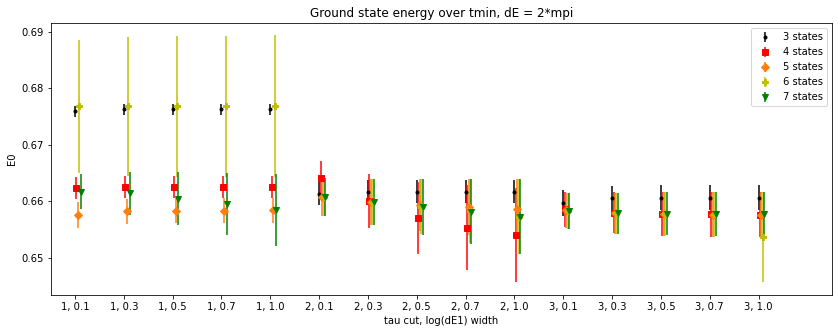

<Figure size 432x288 with 0 Axes>

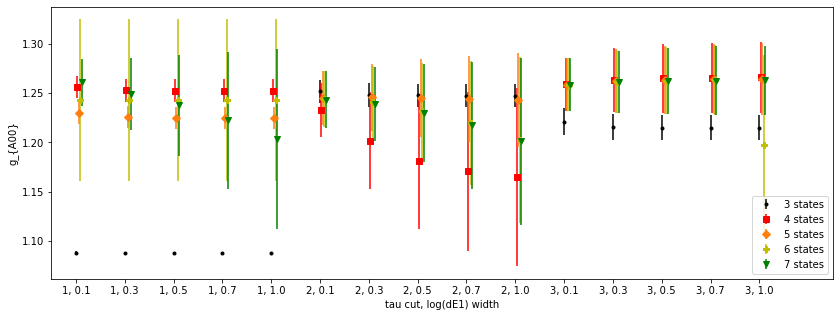

<Figure size 432x288 with 0 Axes>

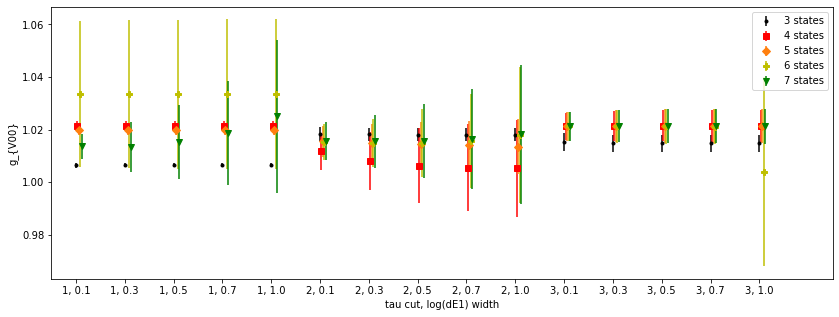

<Figure size 432x288 with 0 Axes>

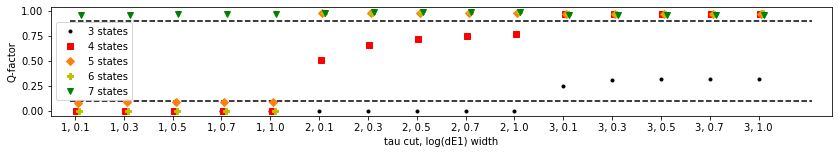

<Figure size 432x288 with 0 Axes>

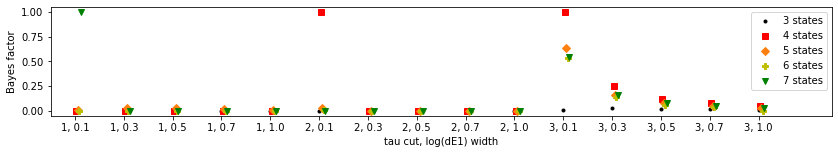

<Figure size 432x288 with 0 Axes>

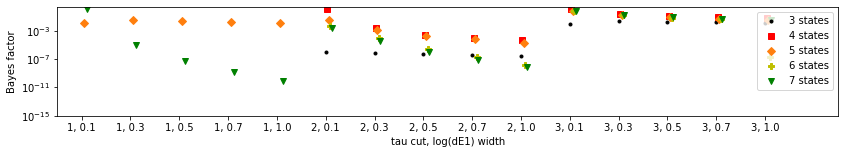

In [61]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

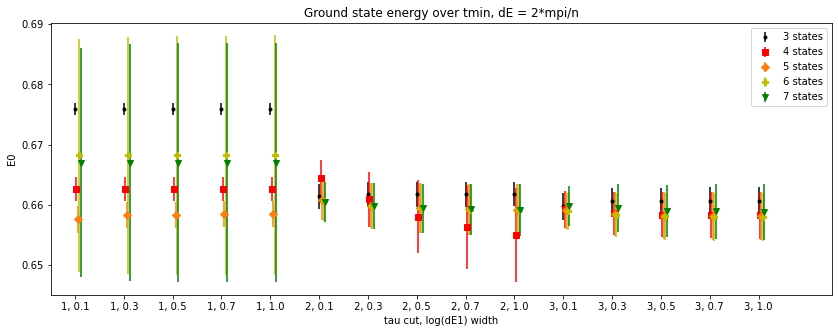

<Figure size 432x288 with 0 Axes>

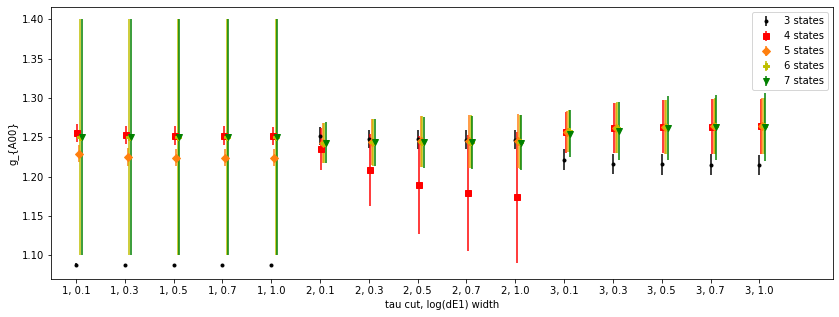

<Figure size 432x288 with 0 Axes>

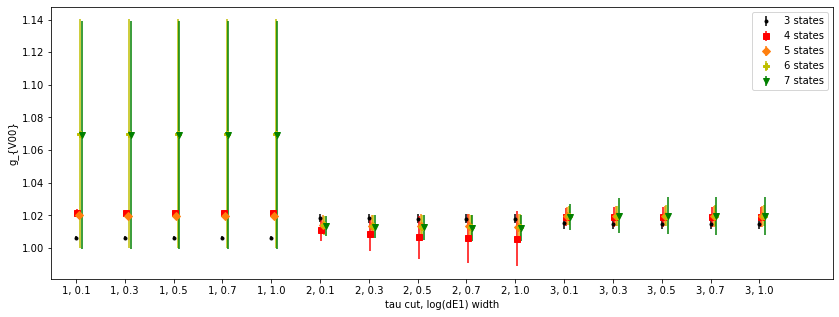

<Figure size 432x288 with 0 Axes>

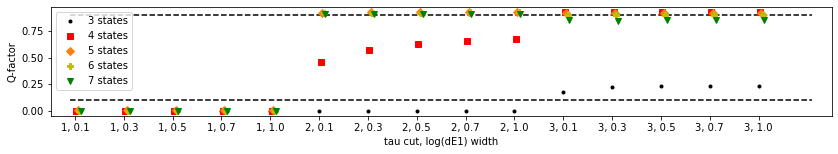

<Figure size 432x288 with 0 Axes>

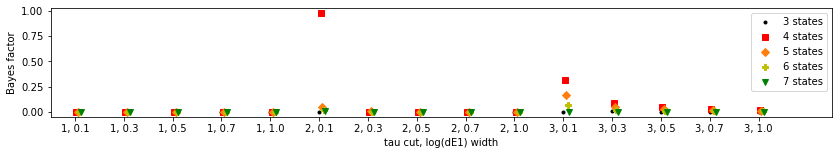

<Figure size 432x288 with 0 Axes>

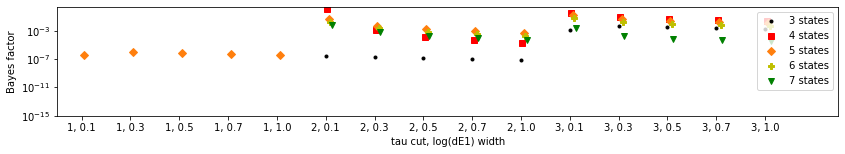

In [62]:
# Now, 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

<Figure size 432x288 with 0 Axes>

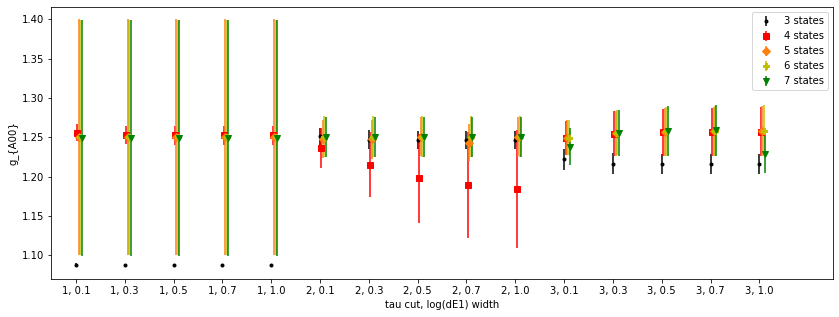

<Figure size 432x288 with 0 Axes>

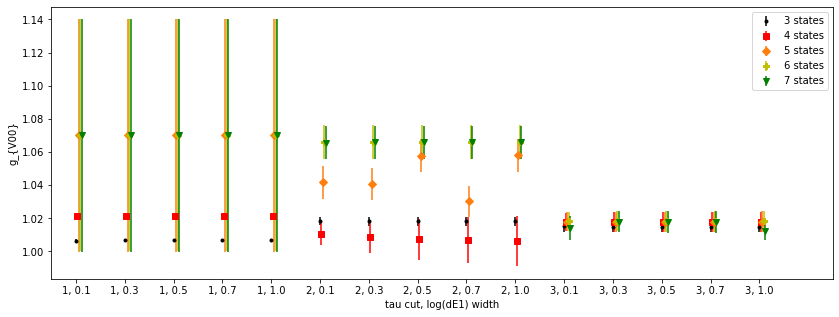

<Figure size 432x288 with 0 Axes>

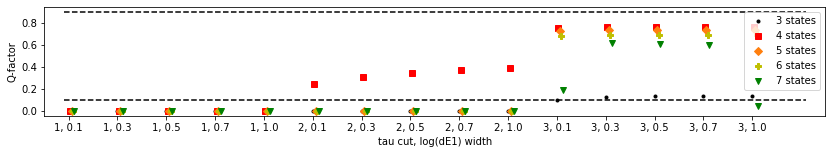

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [63]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()